# Can Topological Divergences Help Predict the Largest Lyapunov Exponent?

## Overview

This notebook generates dynamic system trajectory data then analyses multiple features for supervised learning of the largest Lyapunov exponent (classification and regression). Classical numeric methods, TDA-based methods, Horizontal Visibility methods, and our newly introduced topological divergences are compared.

- classic neighbour-tracing estimators from Rosenstein, Eckmann, and Kantz
- ordinal partition network embedded persistence measures from Myers
- $k$-nearest neighbour graph embedded persistence measures from Myers
- Betti vector norms on embedded trajectories from Güzel
- topological divergences (the main contribution)

Topological divergences are scalar or vector valued measures of the difference between the sublevel and superlevel filtrations over a scalar function.

In [1]:
# collect imports for cells below

import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy import stats
from functools import partial
from TimeSeriesMergeTreeSimple import TimeSeriesMergeTree as TSMT
from ipyparallel import require
import ipyparallel as ipp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tree_offset_divergence import get_offset_divergences
from tree_offset_divergence import div_names as merge_tree_divergence_names
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline
from trajectories import generate_trajectories



In [2]:
# Provide clients to an ipyparallel cluster for faster parallel processing

clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [3]:
# Preprocessing function to remove scale bias in supervised learning

def scale(ts):
    """Make range of ts fall between 0 and 1"""
    scaler = MinMaxScaler()
    return scaler.fit_transform(ts.reshape(-1, 1)).flatten()


## Chaotic system data

In [4]:
# Specify the trajectory generation criteria

SEED = 54321  # consistent random number generation
SAMPLES = 5000  # number of trajectories
LENGTH = 2000  # number of points per trajectory

In [5]:
# Generate the actual system data to analyse

import pickle
import os

filename_train_data = os.path.join("outputs/white_noise", "__".join(map(str, [SEED, LENGTH, SAMPLES])) + "__train_data.pkl")
if not os.path.exists(filename_train_data):
    with open(filename_train_data, "wb") as file:
        data_ = generate_trajectories(RANDOM_SEED=SEED, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=SAMPLES)
        pickle.dump(data_, file)

with open(filename_train_data, "rb") as file:
    system_training_data = pickle.load(file)


In [6]:
!ls -lh outputs/white_noise

total 1.7G
-rw-rw-r-- 1 ab5169 ab5169 170M Sep 16 16:27 54321__2000__5000__108642__2000__1001__test_data.pkl
-rw-rw-r-- 1 ab5169 ab5169 313K Sep 16 22:18 54321__2000__5000__henon__TSMT__False__1__2__1__50__108642__2000__1001__test_features.pkl
-rw-rw-r-- 1 ab5169 ab5169 1.5M Sep 16 22:19 54321__2000__5000__henon__TSMT__False__1__2__1__50__108642__2000__1001__test_predictions.pkl
-rw-rw-r-- 1 ab5169 ab5169 7.9K Sep 16 22:19 54321__2000__5000__henon__TSMT__False__1__2__1__50__108642__2000__1001__test_scores.pkl
-rw-rw-r-- 1 ab5169 ab5169  12M Sep 16 22:18 54321__2000__5000__henon__TSMT__False__1__2__1__50__best_models.pkl
-rw-rw-r-- 1 ab5169 ab5169 1.6M Sep 16 22:07 54321__2000__5000__henon__TSMT__False__1__2__1__50__train_features.pkl
-rw-rw-r-- 1 ab5169 ab5169  74K Sep 16 22:18 54321__2000__5000__henon__TSMT__False__1__2__1__50__train_scores.pkl
-rw-rw-r-- 1 ab5169 ab5169 3.1M Sep 16 17:42 54321__2000__5000__henon__TSMT__False__1__501__50__50__108642__2000__1001__test_features.pkl
-rw-

In [7]:
# Remove relative scale (amplitude) as a feature that could be used in supevised learning

for system in system_training_data:
    trajectories = system_training_data[system]["trajectories"]
    trajectories = list(map(scale, trajectories))
    system_training_data[system]["trajectories"] = trajectories


## Supervised learning

In [8]:
# Define machine learning models to train on the Lyapunov estimates

def score_features_train(feature_names, features, y_true, cv=5, n_repeats=5, ML_SEED=123):
    """Score various supervised ML models on supplied features give a ground truth.
    
    For classification, assumes ground truth y_true>0 is the positive class.
    """

    # assume vectorial features; if scalar, add an extra dimension
    features = np.array(features)
    if features.ndim == 2:
        features = features[..., np.newaxis]
    n_samples, n_features, feature_vector_length = features.shape

    CLASSIFIER_CV = RepeatedStratifiedKFold(n_splits=cv, random_state=ML_SEED, n_repeats=n_repeats)
    REGRESSOR_CV = RepeatedKFold(n_splits=cv, random_state=ML_SEED*2, n_repeats=n_repeats)

    y = y_true
    pos_mask = y>0
    y_classes = y>0

    classification_scorer = "f1"
    regression_scorer = "neg_mean_squared_error"


    for i in range(n_features):
        feature_name = feature_names[i]
        X = features[:, i, :].reshape(n_samples, -1)

        SVC_pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(random_state=ML_SEED))])
        SVC_clf = GridSearchCV(SVC_pipe, {'svc__C':[0.01, 0.1, 1, 10, 100]}, scoring=classification_scorer, n_jobs=-2, refit=True, cv=CLASSIFIER_CV)
        SVC_clf.fit(X, y_classes)
        SVC_scores = cross_val_score(SVC_clf.best_estimator_, X, y_classes, scoring=classification_scorer, cv=CLASSIFIER_CV, n_jobs=-2)

        MLPC_pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(learning_rate='adaptive', random_state=ML_SEED, max_iter=400))])
        MLPC_clf = GridSearchCV(MLPC_pipe, {'mlp__alpha':[0.00001, 0.0001, 0.001, 0.01], 'mlp__hidden_layer_sizes':[(10,), (20,), (10,5,), (20,5)]}, scoring=classification_scorer, n_jobs=-2, refit=True, cv=CLASSIFIER_CV)
        MLPC_clf.fit(X, y_classes)
        MLPC_scores = cross_val_score(MLPC_clf.best_estimator_, X, y_classes, scoring=classification_scorer, cv=CLASSIFIER_CV, n_jobs=-2)

        KNR_all_pipe = Pipeline([('scaler', StandardScaler()), ('knr', KNeighborsRegressor(weights='distance'))])
        KNR_all_clf = GridSearchCV(KNR_all_pipe, {'knr__n_neighbors': [5, 10, 15, 20, 25, 30]}, n_jobs=-2, scoring=regression_scorer, cv=REGRESSOR_CV, refit=True)
        KNR_all_clf.fit(X, y)
        KNR_all_scores = cross_val_score(KNR_all_clf.best_estimator_, X, y, scoring=regression_scorer, cv=REGRESSOR_CV, n_jobs=-2)

        KNR_chaos_pipe = Pipeline([('scaler', StandardScaler()), ('knr', KNeighborsRegressor(weights='distance'))])
        KNR_chaos_clf = GridSearchCV(KNR_chaos_pipe, {'knr__n_neighbors': [5, 10, 15, 20, 25, 30]}, n_jobs=-2, scoring=regression_scorer, cv=REGRESSOR_CV, refit=True)
        KNR_chaos_clf.fit(X[pos_mask], y[pos_mask])
        KNR_chaos_scores = cross_val_score(KNR_chaos_clf.best_estimator_, X[pos_mask], y[pos_mask], scoring=regression_scorer, cv=REGRESSOR_CV, n_jobs=-2)

        SVR_all_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
        SVR_all_clf = GridSearchCV(SVR_all_pipe, {'svr__C':[0.01, 0.1, 1, 10, 100]}, scoring=regression_scorer, n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        SVR_all_clf.fit(X, y)
        SVR_all_scores = cross_val_score(SVR_all_clf.best_estimator_, X, y, scoring=regression_scorer, cv=REGRESSOR_CV, n_jobs=-2)

        SVR_chaos_pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR())])
        SVR_chaos_clf = GridSearchCV(SVR_chaos_pipe, {'svr__C':[0.01, 0.1, 1, 10, 100]}, scoring=regression_scorer, n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        SVR_chaos_clf.fit(X[pos_mask], y[pos_mask])
        SVR_chaos_scores = cross_val_score(SVR_chaos_clf.best_estimator_, X[pos_mask], y[pos_mask], scoring=regression_scorer, cv=REGRESSOR_CV, n_jobs=-2)

        MLPR_all_pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(learning_rate='adaptive', random_state=ML_SEED, max_iter=400))])
        MLPR_all_clf = GridSearchCV(MLPR_all_pipe, {'mlp__alpha':[0.00001, 0.0001, 0.001, 0.01], 'mlp__hidden_layer_sizes':[(10,), (20,), (10,5,), (20,5)]}, scoring=regression_scorer, n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        MLPR_all_clf.fit(X, y)
        MLPR_all_scores = cross_val_score(MLPR_all_clf.best_estimator_, X, y, scoring=regression_scorer, cv=REGRESSOR_CV, n_jobs=-2)

        MLPR_chaos_pipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPRegressor(learning_rate='adaptive', random_state=ML_SEED, max_iter=400))])
        MLPR_chaos_clf = GridSearchCV(MLPR_chaos_pipe, {'mlp__alpha':[0.00001, 0.0001, 0.001, 0.01], 'mlp__hidden_layer_sizes':[(10,), (20,), (10,5,), (20,5)]}, scoring=regression_scorer, n_jobs=-2, refit=True, cv=REGRESSOR_CV)
        MLPR_chaos_clf.fit(X[pos_mask], y[pos_mask])
        MLPR_chaos_scores = cross_val_score(MLPR_chaos_clf.best_estimator_, X[pos_mask], y[pos_mask], scoring=regression_scorer, cv=REGRESSOR_CV, n_jobs=-2)

        # add attribute to check if a model is for all data or just chaotic data
        setattr(KNR_chaos_clf, "chaos", True)
        setattr(SVR_chaos_clf, "chaos", True)
        setattr(MLPR_chaos_clf, "chaos", True)

        yield {
            feature_name: {
                "scores": {
                    "SVC": SVC_scores,
                    "MLPC": MLPC_scores,
                    "KNR_all": KNR_all_scores,
                    "KNR_chaos": KNR_chaos_scores,
                    "SVR_all": SVR_all_scores,
                    "SVR_chaos": SVR_chaos_scores,
                    "MLPR_all": MLPR_all_scores,
                    "MLPR_chaos": MLPR_chaos_scores,
                },
                "models": {
                    "SVC": SVC_clf,
                    "MLPC": MLPC_clf,
                    "KNR_all": KNR_all_clf,
                    "KNR_chaos": KNR_chaos_clf,
                    "SVR_all": SVR_all_clf,
                    "SVR_chaos": SVR_chaos_clf,
                    "MLPR_all": MLPR_all_clf,
                    "MLPR_chaos": MLPR_chaos_clf,
                }
            }
        }


In [9]:
# Apply trained machine models to features from new unseen data

def score_features_test(feature_names, features, y_true, trained_models):
    """Predict using features as input to trained models and score against ground truth.
    
    For classification, assumes ground truth y_true>0 is the positive class.
    """

    # assume vectorial features; if scalar, add an extra dimension
    features = np.array(features)
    if features.ndim == 2:
        features = features[..., np.newaxis]
    n_samples, n_features, feature_vector_length = features.shape
    
    is_classifier = lambda clf: hasattr(clf, "classes_")

    pos_mask = y_true>0

    for i in range(n_features):
        feature_name = feature_names[i]
        X = features[:, i, :].reshape(n_samples, -1)

        yield {
            feature_name: {
                "predictions": {
                    model_name: trained_model.predict(
                        X[pos_mask] if getattr(trained_model, "chaos", False) else X
                    ) for model_name, trained_model in trained_models[feature_name].items()
                },
                "r2_scores": {
                    model_name: trained_model.score(
                        (X[pos_mask] if getattr(trained_model, "chaos", False) else X),
                        (y_true[pos_mask] if getattr(trained_model, "chaos", False) else (pos_mask if is_classifier(trained_model) else y_true))
                    )
                    for model_name, trained_model in trained_models[feature_name].items()
                }
            }
        }

        

## Topological Divergences

First we look at topological merge tree offset path length distributions.

#### Representations

In [10]:
# Set up parameters for the cells below

SYSTEM = "logistic"  # current system being investigated
DISCRETE = True
REP_FUNC = partial(TSMT, discrete=DISCRETE)  # current mode of representing trajectories
OFFSET_MIN, OFFSET_MAX, OFFSET_STEP = 1, 501, 50
OFFSETS = range(OFFSET_MIN, OFFSET_MAX, OFFSET_STEP)  # offsets for merge tree divergences
HISTOGRAM_DIM = 50

In [16]:
# Apply the representation constructor and get a representation of each trajectory

merge_tree_representations_train = list(map(REP_FUNC, system_training_data[SYSTEM]["trajectories"]))

#### Features

In [17]:
# Parallel function to compute divergences for a single merge tree representation

@require(partial=partial, get_offset_divergences=get_offset_divergences, OFFSETS=OFFSETS, HISTOGRAM_DIM=HISTOGRAM_DIM)
def merge_tree_divergence_features(rep):
    import numpy as np
    div_values = list(map(partial(get_offset_divergences, tsmt=rep, histogram_dim=HISTOGRAM_DIM), OFFSETS))
    return np.array(div_values).T


In [18]:
# Generate the merge tree based ML divergence features

import pickle
import os

filename_train_features = "__".join(map(str, [SEED, LENGTH, SAMPLES, SYSTEM, "TSMT", DISCRETE, OFFSET_MIN, OFFSET_MAX, OFFSET_STEP, HISTOGRAM_DIM]))
path_train_features = f"outputs/white_noise/{filename_train_features}__train_features.pkl"
if not os.path.exists(path_train_features):
    with open(path_train_features, "wb") as file:
        # Compute the divergences for each merge tree representation in parallel
        data_ = lbv.map_sync(merge_tree_divergence_features, merge_tree_representations_train)
        # Convert list to array of shape (n_trajectories, n_divergences, vector_length)
        data_ = np.array(data_)
        pickle.dump(data_, file)

with open(path_train_features, "rb") as file:
    merge_tree_divergence_features_train = pickle.load(file)


### Training

#### Ground truth

In [11]:
# Define the ground truth for model training

y_train = system_training_data[SYSTEM]["lces"]
train_params = system_training_data[SYSTEM]["sys_params"]

In [20]:
import pickle
filename = "__".join(map(str, [SEED, LENGTH, SAMPLES, SYSTEM, "TSMT", DISCRETE, OFFSET_MIN, OFFSET_MAX, OFFSET_STEP, HISTOGRAM_DIM]))

if not os.path.exists(f"outputs/white_noise/{filename}__train_scores.pkl"):
    # Compute the supervised learning model scores for the topological divergence features on training data
    merge_tree_divergence_train_results = {}
    for result in score_features_train(merge_tree_divergence_names, merge_tree_divergence_features_train, y_train):
        merge_tree_divergence_train_results |= result

    # Extract the scores and the best-performing models from the results dictionary
    merge_tree_divergence_train_scores = {k:v["scores"] for k,v in merge_tree_divergence_train_results.items()}
    merge_tree_divergence_train_best_models = {k:v["models"] for k,v in merge_tree_divergence_train_results.items()}

    with open(f"outputs/white_noise/{filename}__train_scores.pkl", "wb") as file:
        pickle.dump(merge_tree_divergence_train_scores, file)
    with open(f"outputs/white_noise/{filename}__best_models.pkl", "wb") as file:
        pickle.dump(merge_tree_divergence_train_best_models, file)

with open(f"outputs/white_noise/{filename}__train_scores.pkl", "rb") as file:
    merge_tree_divergence_train_scores = pickle.load(file)
with open(f"outputs/white_noise/{filename}__best_models.pkl", "rb") as file:
    merge_tree_divergence_train_best_models = pickle.load(file)


In [22]:
# Display the mean scores for the supervised learning using each divergence

merge_tree_divergence_train_scores_df = pd.DataFrame(merge_tree_divergence_train_scores)
merge_tree_divergence_train_scores_df_means = merge_tree_divergence_train_scores_df.applymap(np.mean).T
merge_tree_divergence_train_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
path_length_l1,0.991661,0.991579,-0.016255,-0.007739,-0.015704,-0.007122,-0.018280,-0.009573
path_length_l2,0.991455,0.991296,-0.018489,-0.010233,-0.018045,-0.009109,-0.020950,-0.012250
path_length_linf,0.937439,0.936687,-0.055161,-0.014424,-0.053346,-0.014208,-0.055171,-0.016521
path_length_l1_rev,0.904240,0.902591,-0.069723,-0.011367,-0.070171,-0.010472,-0.070730,-0.013883
path_length_l2_rev,0.902341,0.900266,-0.066571,-0.009228,-0.069112,-0.008956,-0.069088,-0.011894
path_length_linf_rev,0.904196,0.903420,-0.077672,-0.013332,-0.081153,-0.013085,-0.077867,-0.015189
path_length_hist_w,0.985991,0.985440,-0.015211,-0.003116,-0.015532,-0.004029,-0.017367,-0.004423
path_length_hist_l1,0.931103,0.927418,-0.057520,-0.009316,-0.054745,-0.007931,-0.058303,-0.010909
path_length_hist_l2,0.935679,0.933438,-0.057217,-0.010078,-0.053862,-0.007660,-0.060015,-0.011646
path_length_hist_linf,0.949803,0.950921,-0.049411,-0.010816,-0.049915,-0.006692,-0.053718,-0.011348


In [23]:
best_svr_all_feature_train = merge_tree_divergence_train_scores_df_means["SVR_all"].idxmax()
best_svc_feature_train = merge_tree_divergence_train_scores_df_means["SVC"].idxmax()
best_svc_feature_train, best_svr_all_feature_train

('cophenetic_weight_l1', 'cophenetic_weight_hist_l2')

### Predictions

To illustrate the predictive power of the resulting feature(s) we use computed divergences for training and predict $\lambda_{\max}$ for new unseen trajectories.

#### Test Data

In [12]:
TEST_SEED = SEED * 2
TEST_LENGTH = LENGTH
TEST_SAMPLES = 1001


In [13]:
# Generate the test system data to analyse

import pickle
import os

filename_test_data = os.path.join("outputs/white_noise", "__".join(map(str, [SEED, LENGTH, SAMPLES, TEST_SEED, TEST_LENGTH, TEST_SAMPLES])) + "__test_data.pkl")
if not os.path.exists(filename_test_data):
    with open(filename_test_data, "wb") as file:
        data_ = generate_trajectories(RANDOM_SEED=TEST_SEED, TS_LENGTH=TEST_LENGTH, CONTROL_PARAM_SAMPLES=TEST_SAMPLES)
        pickle.dump(data_, file)

with open(filename_test_data, "rb") as file:
    system_test_data = pickle.load(file)


In [14]:
test_trajectories = system_test_data[SYSTEM]["trajectories"]
test_param_name = system_test_data[SYSTEM]["param_name"]
test_params = system_test_data[SYSTEM]["sys_params"]
y_test = system_test_data[SYSTEM]["lces"]

In [15]:
# Remove relative scale (amplitude) as a feature that could be used in supevised learning

for system in system_test_data:
    trajectories = system_test_data[system]["trajectories"]
    trajectories = list(map(scale, trajectories))
    system_test_data[system]["trajectories"] = trajectories


#### Test Features

In [28]:
import pickle

filename_test_features = os.path.join("outputs/white_noise", "__".join(map(str, [SEED, LENGTH, SAMPLES, SYSTEM, "TSMT", DISCRETE, OFFSET_MIN, OFFSET_MAX, OFFSET_STEP, HISTOGRAM_DIM, TEST_SEED, TEST_LENGTH, TEST_SAMPLES])) + "__test_features.pkl")
if not os.path.exists(filename_test_features):
    with open(filename_test_features, "wb") as file:
        merge_tree_representations_test = list(map(REP_FUNC, test_trajectories))
        merge_tree_divergence_features_test = lbv.map_sync(merge_tree_divergence_features, merge_tree_representations_test)
        merge_tree_divergence_features_test = np.array(merge_tree_divergence_features_test)
        pickle.dump(merge_tree_divergence_features_test, file)

with open(filename_test_features, "rb") as file:
    merge_tree_divergence_features_test = pickle.load(file)


### Test results

In [29]:

import pickle
filename_test = "__".join(map(str, [SEED, LENGTH, SAMPLES, SYSTEM, "TSMT", DISCRETE, OFFSET_MIN, OFFSET_MAX, OFFSET_STEP, HISTOGRAM_DIM, TEST_SEED, TEST_LENGTH, TEST_SAMPLES]))

if not os.path.exists(f"outputs/white_noise/{filename_test}__test_scores.pkl"):
    merge_tree_divergence_test_results = {}

    for result in score_features_test(merge_tree_divergence_names, merge_tree_divergence_features_test, y_test, merge_tree_divergence_train_best_models):
        merge_tree_divergence_test_results |= result

    merge_tree_divergence_test_scores = {k:v["r2_scores"] for k,v in merge_tree_divergence_test_results.items()}
    merge_tree_divergence_test_predictions = {k:v["predictions"] for k,v in merge_tree_divergence_test_results.items()}

    with open(f"outputs/white_noise/{filename_test}__test_scores.pkl", "wb") as file:
        pickle.dump(merge_tree_divergence_test_scores, file)
    with open(f"outputs/white_noise/{filename_test}__test_predictions.pkl", "wb") as file:
        pickle.dump(merge_tree_divergence_test_predictions, file)

with open(f"outputs/white_noise/{filename_test}__test_scores.pkl", "rb") as file:
    merge_tree_divergence_test_scores = pickle.load(file)
with open(f"outputs/white_noise/{filename_test}__test_predictions.pkl", "rb") as file:
    merge_tree_divergence_test_predictions = pickle.load(file)


In [31]:
# Display the mean scores for the supervised learning using each divergence

merge_tree_divergence_test_scores_df = pd.DataFrame(merge_tree_divergence_test_scores)
merge_tree_divergence_test_scores_df_means = merge_tree_divergence_test_scores_df.applymap(np.mean).T
merge_tree_divergence_test_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
path_length_l1,0.992424,0.993051,-0.013694,-0.007505,-0.013834,-0.006657,-0.015496,-0.008904
path_length_l2,0.990560,0.989899,-0.016435,-0.009686,-0.016596,-0.008374,-0.019332,-0.011375
path_length_linf,0.943373,0.941984,-0.054240,-0.014423,-0.048630,-0.013734,-0.052848,-0.015381
path_length_l1_rev,0.910891,0.914049,-0.065185,-0.011014,-0.067410,-0.010286,-0.066316,-0.013211
path_length_l2_rev,0.910456,0.910256,-0.061246,-0.008683,-0.063410,-0.008062,-0.063533,-0.011488
path_length_linf_rev,0.910138,0.912565,-0.074311,-0.012814,-0.077964,-0.012426,-0.073306,-0.013771
path_length_hist_w,0.990607,0.990607,-0.012002,-0.002736,-0.011974,-0.003568,-0.013689,-0.003564
path_length_hist_l1,0.941693,0.933499,-0.053981,-0.009171,-0.051051,-0.007332,-0.052511,-0.010214
path_length_hist_l2,0.944617,0.936170,-0.053856,-0.009719,-0.050602,-0.007095,-0.056538,-0.009741
path_length_hist_linf,0.961803,0.961611,-0.042514,-0.010329,-0.044336,-0.005859,-0.050255,-0.009045


### Test results visualisation

In [83]:
prediction_feature_name = "cophenetic_weight_l2_rev"
prediction_feature_name = "cophenetic_weight_l1"
prediction_feature_name = "path_weight_hist_linf"
prediction_feature_name = "cophenetic_length_l1"
prediction_feature_name = "path_length_l1_rev"
prediction_feature_name = "path_weight_hist_l1"
prediction_feature_name = "path_weight_l2_rev"
prediction_feature_name = "path_length_hist_w"
prediction_feature_name = "path_weight_l2"
prediction_feature_name = "path_weight_hist_w"
prediction_feature_name = "cophenetic_weight_hist_l1"
prediction_feature_name = "path_length_l2_rev"
prediction_feature_name = "path_weight_linf_rev"
prediction_feature_name = "path_length_l1"
prediction_feature_name = "cophenetic_weight_hist_w"
prediction_feature_name = "cophenetic_weight_l1_rev"
prediction_feature_name = "cophenetic_length_l2_rev"
prediction_feature_name = "path_weight_hist_l2"
prediction_feature_name = "cophenetic_weight_hist_l2"
prediction_model_name = "SVR_all"
y_pred = merge_tree_divergence_test_predictions[prediction_feature_name][prediction_model_name]


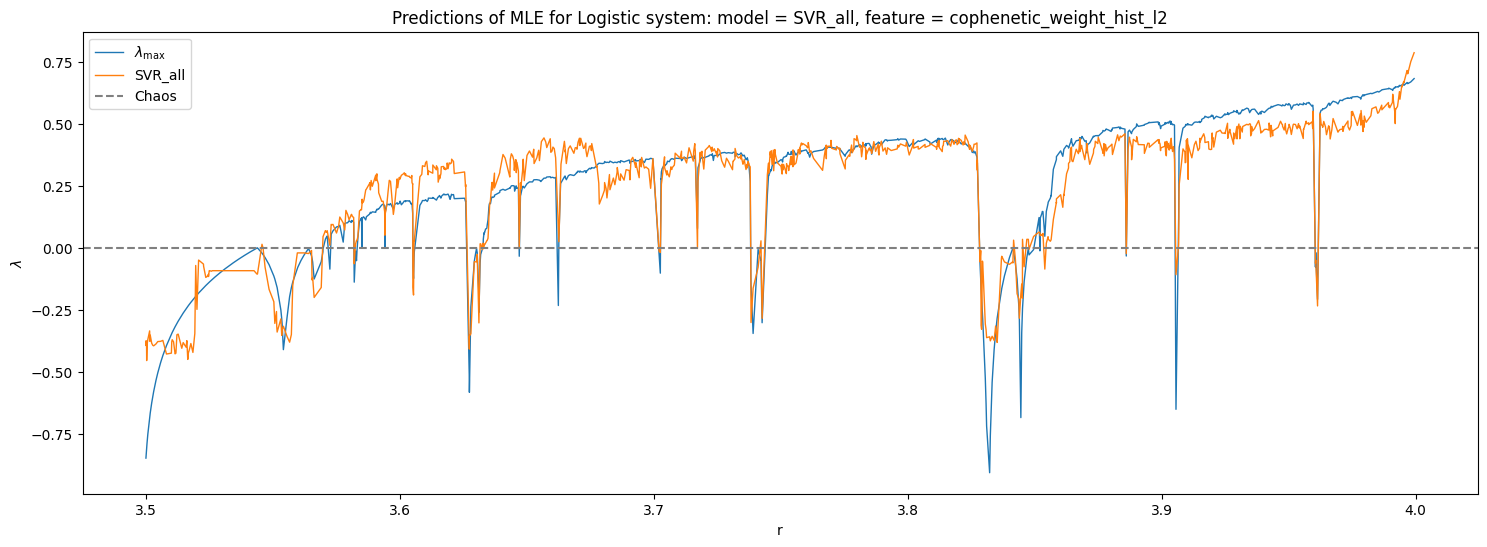

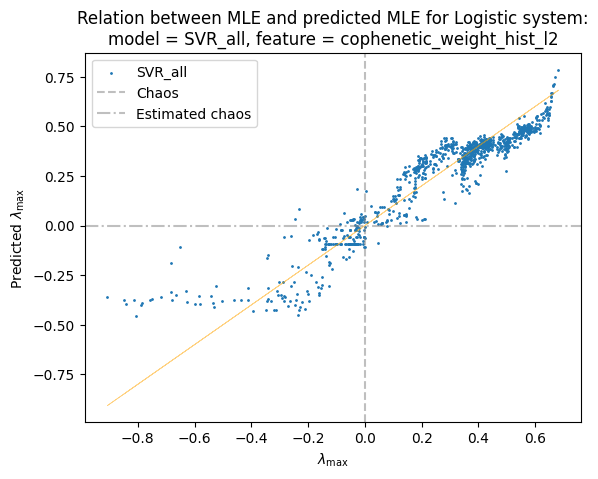

In [84]:
# plot the ground truth and regression predictions
plt.figure(figsize=(18,6))
plt.plot(test_params, y_test, lw=1, label=r"$\lambda_{\max}$")
# plt.plot(np.array(test_params)[y_test>0], y_pred, lw=1, label=prediction_model_name)
plt.plot(test_params, y_pred, lw=1, label=prediction_model_name)
plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(f"Predictions of MLE for {SYSTEM.capitalize()} system: model = {prediction_model_name}, feature = {prediction_feature_name}")
plt.show()

# plot the relation between prediction and ground truth
# plt.figure(figsize=(9,6))
plt.scatter(y_test, y_pred, s=1, label=prediction_model_name)
plt.plot(y_test, y_test, c="orange", lw=0.5, alpha=0.5)
plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
plt.xlabel(r"$\lambda_{\max}$")
plt.ylabel(r"Predicted $\lambda_{\max}$")
plt.legend()
plt.title(f"Relation between MLE and predicted MLE for {SYSTEM.capitalize()} system:\nmodel = {prediction_model_name}, feature = {prediction_feature_name}")
plt.show()

In [35]:
stats.pearsonr(y_pred, y_test), stats.spearmanr(y_pred, y_test)

(PearsonRResult(statistic=0.9345602878851857, pvalue=0.0),
 SignificanceResult(statistic=0.9302428718408193, pvalue=0.0))

In [36]:
prediction_feature_name = "cophenetic_weight_l1_rev"
prediction_feature_name = "cophenetic_weight_linf"
prediction_feature_name = "path_length_l1"
prediction_feature_name = "cophenetic_length_l1"
prediction_feature_name = "cophenetic_weight_hist_l1"
prediction_feature_name = "path_weight_hist_linf"
prediction_feature_name = "cophenetic_weight_l1"
prediction_feature_name = "path_weight_hist_l2"
prediction_feature_name = "cophenetic_weight_hist_linf"
prediction_feature_name = "path_length_hist_w"
prediction_feature_name = "path_length_l1_rev"
prediction_feature_name = "path_length_hist_linf"
prediction_feature_name = "path_length_l2_rev"
prediction_feature_name = "path_length_l2"
prediction_feature_name = "cophenetic_length_l2_rev"
prediction_feature_name = "cophenetic_length_hist_l2"
prediction_feature_name = "cophenetic_length_hist_w"
prediction_feature_name = "cophenetic_weight_hist_l2"
prediction_model_name = "SVC"
y_pred = merge_tree_divergence_test_predictions[prediction_feature_name][prediction_model_name]

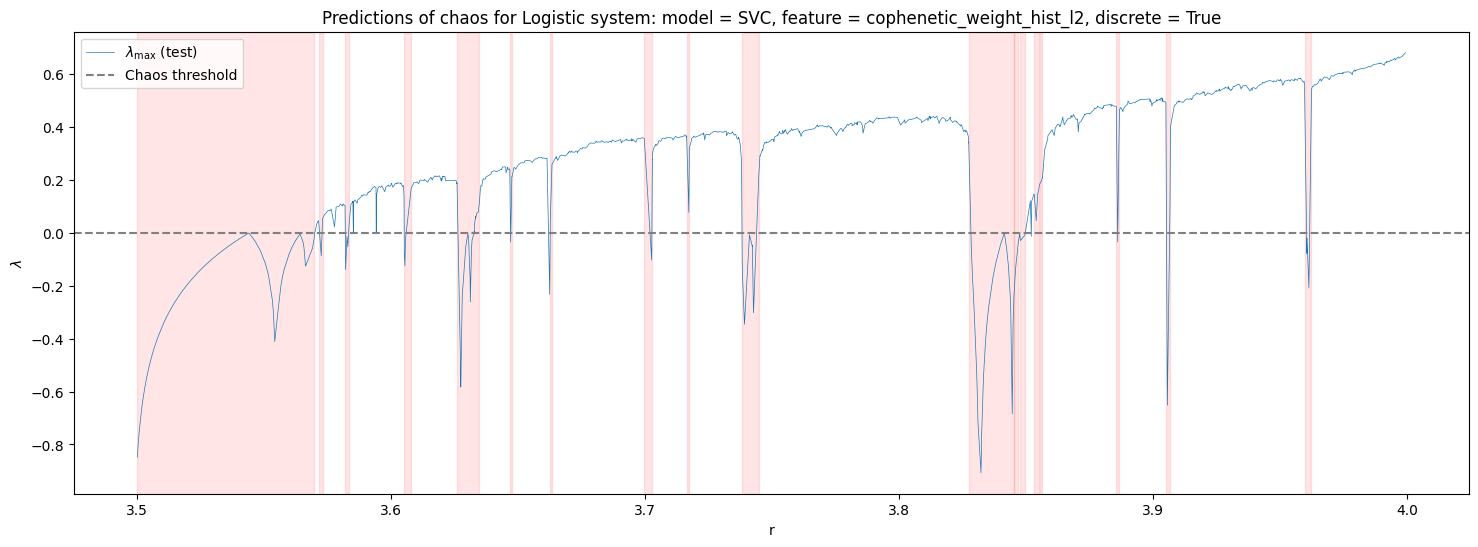

In [37]:
# plot the ground truth
plt.figure(figsize=(18,6))
# plt.plot(train_params, y_train, lw=0.5, label=r"$\lambda_{\max}$ (train)")
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$ (test)")

# plot the classification predictions as vspans over the graph
# predicted_non_chaos = y_pred <= 0
predicted_non_chaos = y_pred == False
x = test_params

# mark sections of the x-axis where predicted_non_chaos is True
start = x[0] if predicted_non_chaos[0] else None
for i in range(1, len(predicted_non_chaos)):
    if not predicted_non_chaos[i-1] and predicted_non_chaos[i]:
        start = x[i-1]
    elif predicted_non_chaos[i-1] and not predicted_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)
            start = None
    elif i == len(predicted_non_chaos)-1:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(f"Predictions of chaos for {SYSTEM.capitalize()} system: model = {prediction_model_name}, feature = {prediction_feature_name}, discrete = {DISCRETE}")
plt.show()


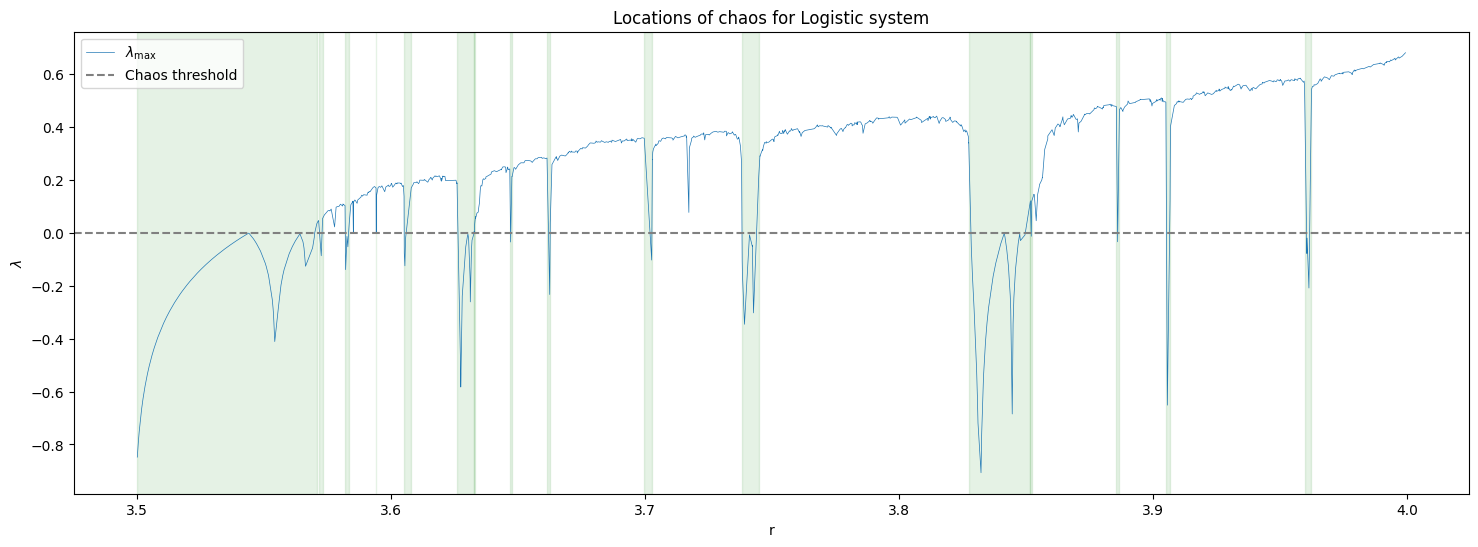

In [38]:
# plot the ground truth
plt.figure(figsize=(18,6))
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")

# plot the classification predictions as vspans over the graph
# actual_non_chaos = y_pred < 0.025
actual_non_chaos = y_test < 0
x = test_params

# mark sections of the x-axis where actual_non_chaos is True
start = x[0] if actual_non_chaos[0] else None
for i in range(1, len(actual_non_chaos)):
    if not actual_non_chaos[i-1] and actual_non_chaos[i]:
        start = x[i-1]
    elif actual_non_chaos[i-1] and not actual_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='green', alpha=0.1)
            start = None
    elif i == len(actual_non_chaos)-1:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='green', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(f"Locations of chaos for {SYSTEM.capitalize()} system")
plt.show()


### Hyperparameters of the divergence-based estimates above

The following can be considered for variation in a wider-range study.

- Offset range and step size - equivalently offset range and number of offsets
- Dimension of the histogram vectors being compared
- Discrete vs piecewise linear merge trees


## Classic Estimators

We compute the Rosenstein, Eckmann, and Kantz neighbour-tracing algorithms as benchmarks. These are direct estimates of $\lambda_{\max}$ so we can score the predictions directly, and can also score them as features for a supervised learning and prediction pipeline as above.

In [60]:
# import the classic estimators
from classic_estimators import get_classic_estimates, classic_names

In [20]:
# define utility functions

def make_inf_column_finite(arr):
    """Convert -inf and +inf to min finite value in each column."""

    arr_isinf = np.isinf(arr)
    col_mins = np.min(ma.masked_array(arr, mask=arr_isinf, fill_value=0), axis=0)

    for row_idx in range(arr.shape[0]):
        for col_idx in range(arr.shape[1]):
            if np.isinf(arr[row_idx, col_idx]):
                arr[row_idx, col_idx] = col_mins[col_idx]
                arr[np.isnan(arr)] = -1e-12

    return arr

def get_scores_from_predictions(y_pred, y_true=None):
    """Compute f1 and negative mean squared error scores for predictions."""
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import f1_score
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    chaos = y_true > 0
    mse_all = mean_squared_error(y_true, y_pred)
    mse_chaos = mean_squared_error(y_true[chaos], y_pred[chaos])
    f1_all = f1_score(chaos, y_pred>0)
    spearmanr_all = stats.spearmanr(y_pred, y_true)[0]
    pearsonr_all = stats.pearsonr(y_pred, y_true)[0]
    spearmanr_chaos = stats.spearmanr(y_pred[chaos], y_true[chaos])[0]
    pearsonr_chaos = stats.pearsonr(y_pred[chaos], y_true[chaos])[0]

    results = {
        "f1": f1_all,
        "mse_all": -mse_all,
        "mse_chaos": -mse_chaos,
        "spearmanr_all": spearmanr_all,
        "spearmanr_chaos": spearmanr_chaos,
        "pearsonr_all": pearsonr_all,
        "pearsonr_chaos": pearsonr_chaos,
    }

    return results


### Direct scoring of classic estimates

Estimate $\lambda_{\max}$ for each of the test trajectories. Compute the f1 score for classification, the negative mean squared error (MSE) score for regression, and the Spearman and Pearson correlation coefficients.

In [62]:
kantz_k_neighbours = 10
classic_estimates_test = list(lbv.map_sync(partial(get_classic_estimates, kantz_k_neighbours=kantz_k_neighbours), system_test_data[SYSTEM]["trajectories"]))
classic_estimates_test = np.array(classic_estimates_test)
classic_estimates_test = make_inf_column_finite(classic_estimates_test)

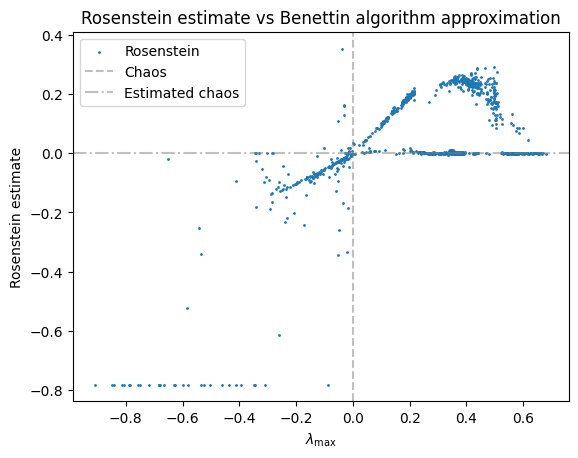

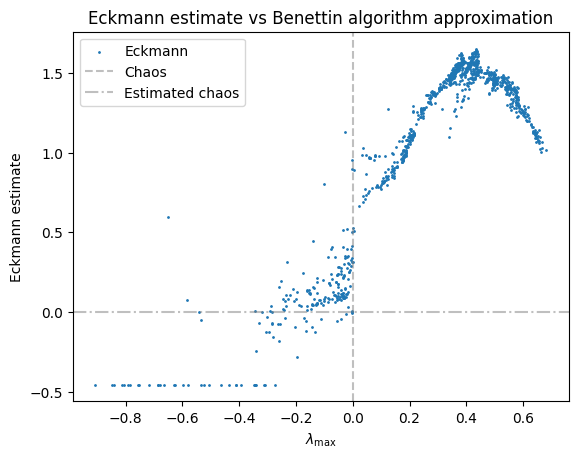

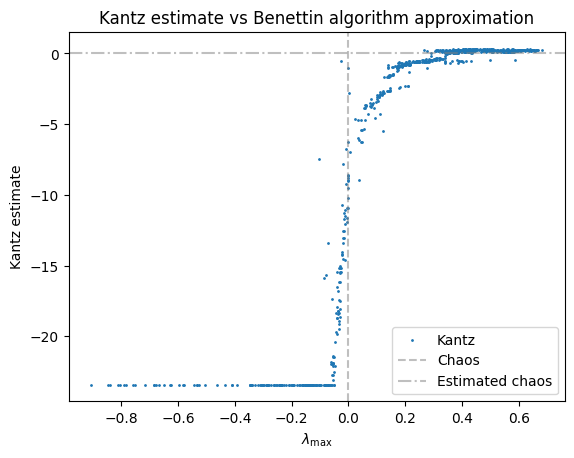

In [63]:
for estimate_name, estimates in zip(classic_names, classic_estimates_test.T):
    plt.scatter(system_test_data[SYSTEM]["lces"], estimates, s=1, label=estimate_name)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.title(f"{estimate_name} estimate vs Benettin algorithm approximation")
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(f"{estimate_name} estimate")
    plt.legend()
    plt.show()



In [64]:
classic_test_scores_iter = map(partial(get_scores_from_predictions, y_true=y_test), classic_estimates_test.T)
classic_test_scores_df = pd.DataFrame(classic_test_scores_iter)
classic_test_scores_df.index = classic_names

In [65]:
classic_test_scores_df

,f1,mse_all,mse_chaos,spearmanr_all,spearmanr_chaos,pearsonr_all,pearsonr_chaos
Rosenstein,0.903924,-0.096602,-0.116117,0.374268,-0.179239,0.618739,-0.127117
Eckmann,0.913923,-0.774594,-0.954883,0.666239,0.329502,0.885896,0.537097
Kantz,0.814093,-90.438876,-1.565167,0.892081,0.784822,0.864095,0.734160


### Supervised learning pipeline with classic estimates

We can improve the raw estimates by using them as a feature in a supervised learning pipeline, then predicting $\lambda_{\max}$ using the resulting trained models.

In [66]:
classic_estimates_train = list(lbv.map_sync(get_classic_estimates, system_training_data[SYSTEM]["trajectories"]))
classic_estimates_train = np.array(classic_estimates_train)
classic_estimates_train = make_inf_column_finite(classic_estimates_train)

In [67]:
classic_ml_results_train = {SYSTEM: {}}
for result in score_features_train(classic_names, classic_estimates_train[..., np.newaxis], y_train):
    # print(result)
    classic_ml_results_train[SYSTEM] |= result

/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/SP/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/SP/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/SP/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/SP/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning:

In [68]:
classic_ml_train_scores = {k:v["scores"] for k,v in classic_ml_results_train[SYSTEM].items()}
classic_ml_train_models = {k:v["models"] for k,v in classic_ml_results_train[SYSTEM].items()}

In [69]:
# Display the mean scores for the supervised learning using each classic estmate

classic_ml_train_scores_df = pd.DataFrame(classic_ml_train_scores)
classic_ml_train_scores_df_means = classic_ml_train_scores_df.applymap(np.mean).T
classic_ml_train_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
Rosenstein,0.974780,0.983844,-0.022140,-0.018016,-0.033204,-0.016296,-0.032327,-0.018196
Eckmann,0.996802,0.996928,-0.017276,-0.014551,-0.014988,-0.013097,-0.015103,-0.012757
Kantz,0.995927,0.995539,-0.041295,-0.006319,-0.014200,-0.006618,-0.016903,-0.005997


In [70]:
classic_ml_test_results = {}
for result in score_features_test(classic_names, classic_estimates_test, y_test, classic_ml_train_models):
        classic_ml_test_results |= result

classic_ml_test_scores = {k:v["r2_scores"] for k,v in classic_ml_test_results.items()}
classic_ml_test_predictions = {k:v["predictions"] for k,v in classic_ml_test_results.items()}

    

In [71]:
# Display the mean scores for the supervised learning using each classic estimate

classic_ml_test_scores_df = pd.DataFrame(classic_ml_test_scores)
classic_ml_test_scores_df_means = classic_ml_test_scores_df.applymap(np.mean).T
classic_ml_test_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
Rosenstein,0.977750,0.981343,-0.022160,-0.018668,-0.032220,-0.017212,-0.031032,-0.019074
Eckmann,0.996217,0.996845,-0.018307,-0.014833,-0.014949,-0.013170,-0.015251,-0.012572
Kantz,0.994962,0.995589,-0.012914,-0.006703,-0.012451,-0.006701,-0.014883,-0.006023


In [72]:
classic_svr_all_predictions = {k: v["SVR_all"] for k, v in classic_ml_test_predictions.items()}

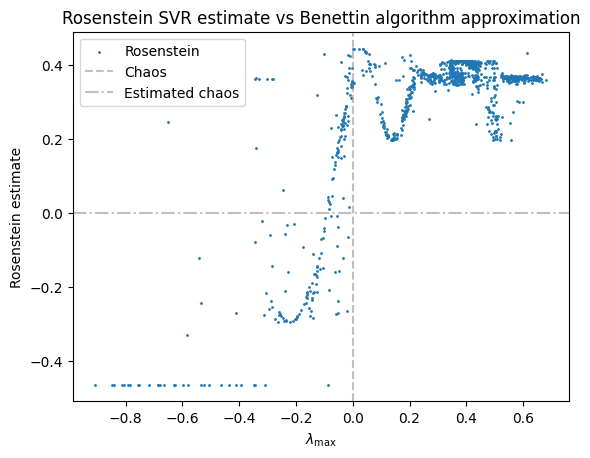

PearsonRResult(statistic=0.7791208068447545, pvalue=7.8181913086909785e-205)
SignificanceResult(statistic=0.46326746569996186, pvalue=2.127753743708863e-54)


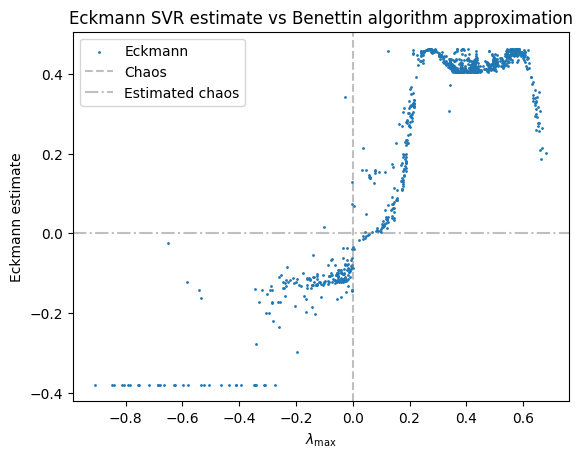

PearsonRResult(statistic=0.904505351084735, pvalue=0.0)
SignificanceResult(statistic=0.7260173581833523, pvalue=1.2230187703871899e-164)


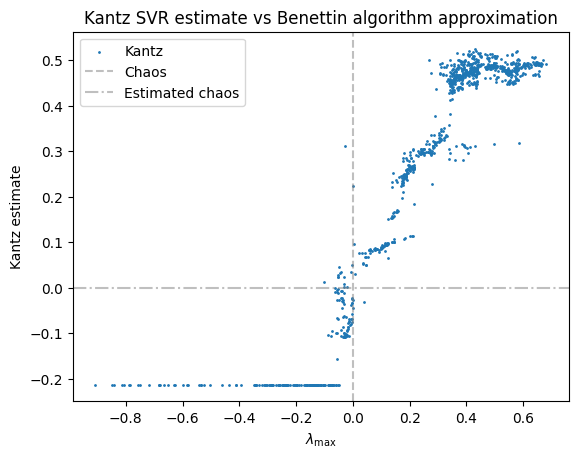

PearsonRResult(statistic=0.9247517036488795, pvalue=0.0)
SignificanceResult(statistic=0.8915313038103173, pvalue=0.0)


In [73]:
for estimate_name, estimates in classic_svr_all_predictions.items():
    lces_true = system_test_data[SYSTEM]["lces"]
    plt.scatter(lces_true, estimates, s=1, label=estimate_name)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.title(f"{estimate_name} SVR estimate vs Benettin algorithm approximation")
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(f"{estimate_name} estimate")
    plt.legend()
    plt.show()
    print(stats.pearsonr(lces_true, estimates))
    print(stats.spearmanr(lces_true, estimates))



As expected from the high nonlinear Spearman correlation, the Kantz estimate achieves the highest regression performance on the held-out test set. Similarly, the high linear Pearson correlation for the Eckmann estimate leads to the highest classification performance on the held-out test set.

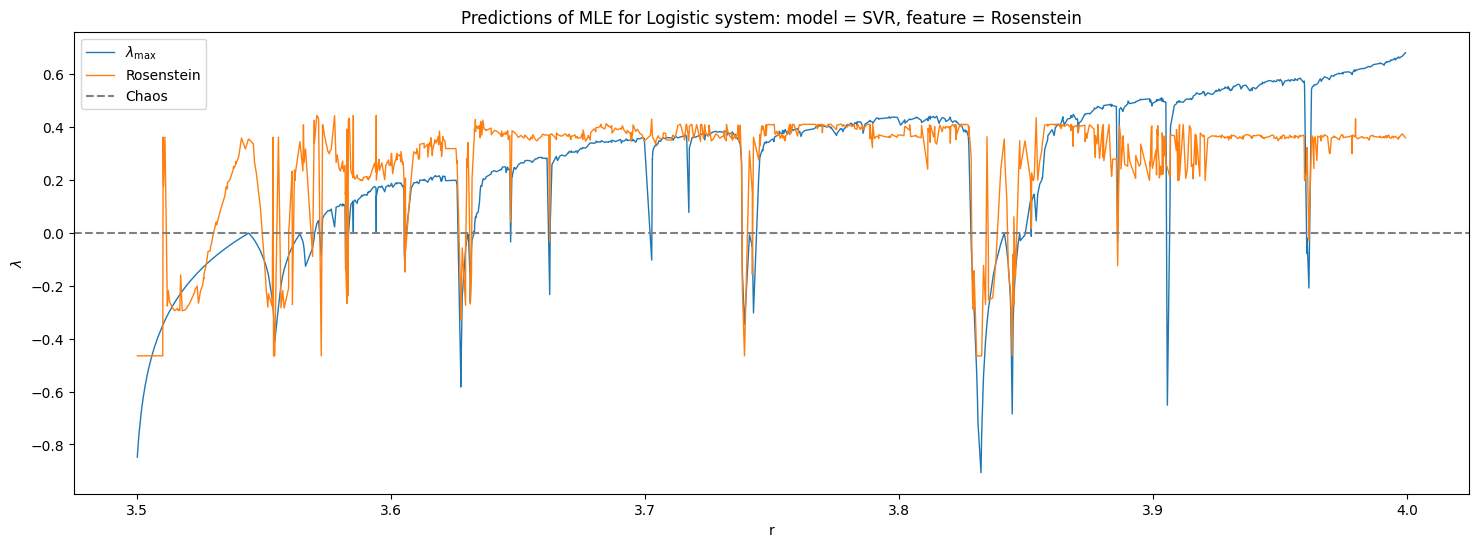

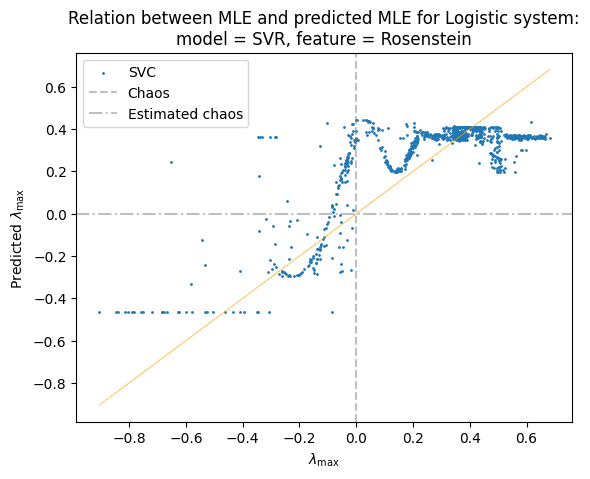

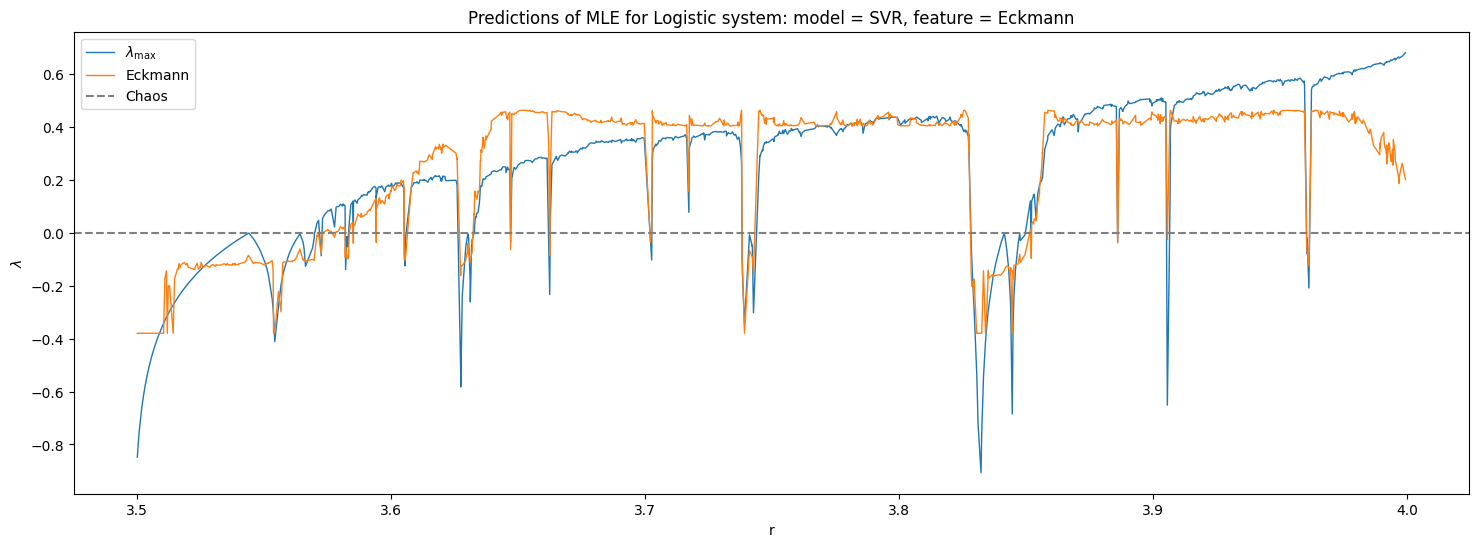

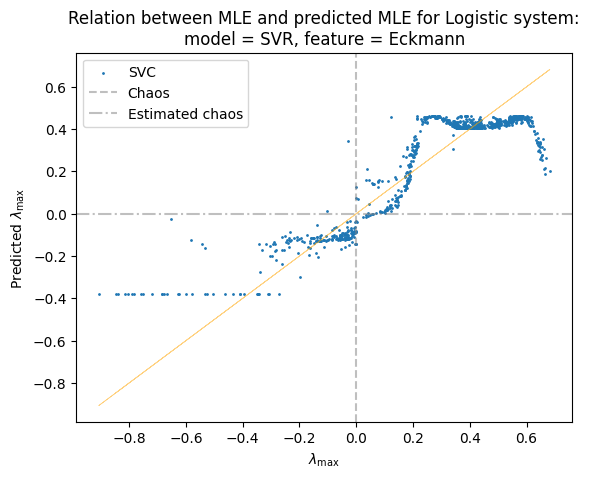

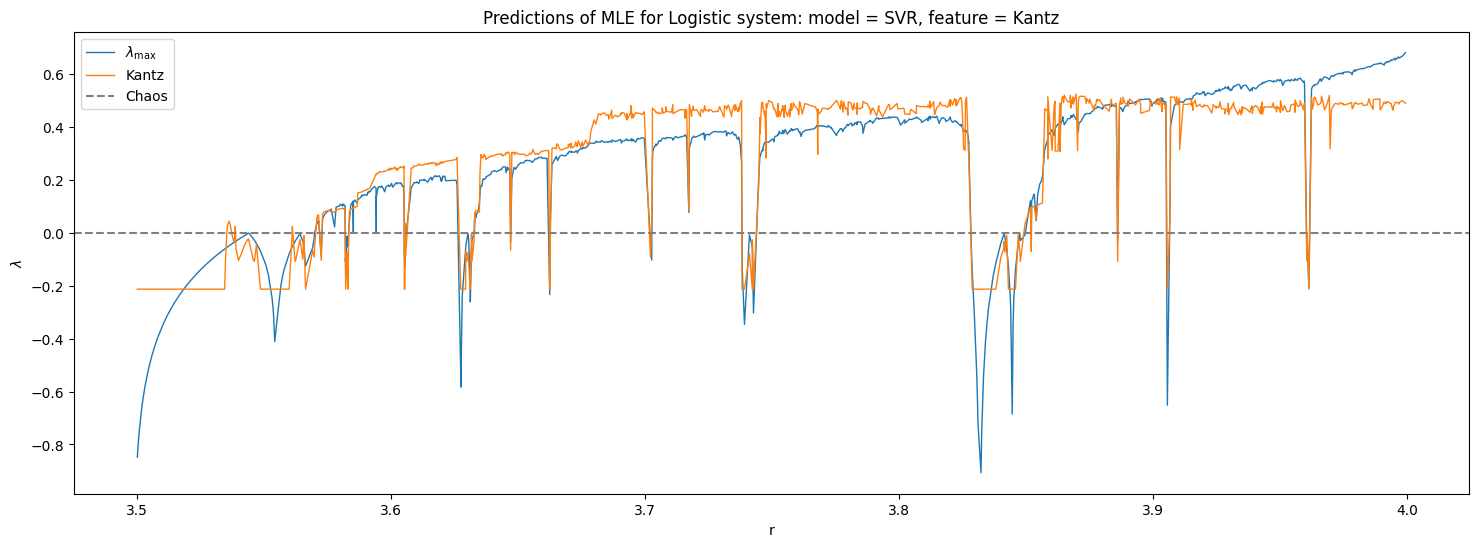

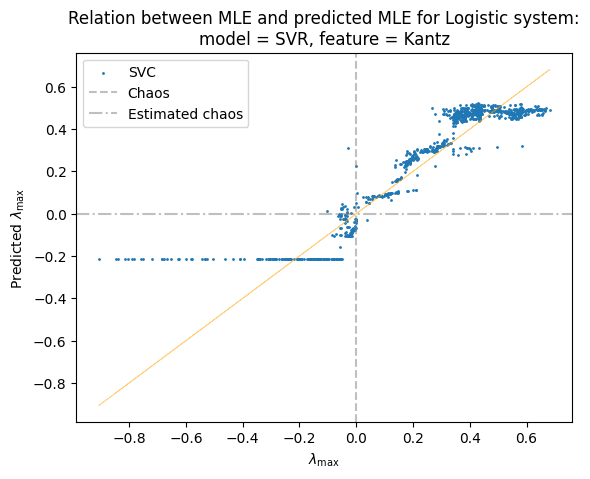

In [75]:
for estimate_name, y_pred in classic_svr_all_predictions.items():
    # plot the ground truth and regression predictions
    plt.figure(figsize=(18,6))
    plt.plot(test_params, y_test, lw=1, label=r"$\lambda_{\max}$")
    # plt.plot(np.array(test_params)[y_test>0], y_pred, lw=1, label=prediction_model_name)
    plt.plot(test_params, y_pred, lw=1, label=estimate_name)
    plt.xlabel(test_param_name)
    plt.ylabel(r"$\lambda$")
    plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
    plt.legend()
    plt.title(f"Predictions of MLE for {SYSTEM.capitalize()} system: model = SVR, feature = {estimate_name}")
    plt.show()

    # plot the relation between prediction and ground truth
    # plt.figure(figsize=(9,6))
    plt.scatter(y_test, y_pred, s=1, label=prediction_model_name)
    plt.plot(y_test, y_test, c="orange", lw=0.5, alpha=0.5)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(r"Predicted $\lambda_{\max}$")
    plt.legend()
    plt.title(f"Relation between MLE and predicted MLE for {SYSTEM.capitalize()} system:\nmodel = SVR, feature = {estimate_name}")
    plt.show()

## Betti Curve Norm Estimators

We compute the $\ell_1$ norms of the 0-d and 1-d Betti vectors of VR persistence of a delay embedding.

In [41]:
# import the classic estimators
from crocker_estimates import get_crocker_estimates, crocker_names

### Direct scoring of Betti curve estimates

Estimate $\lambda_{\max}$ for each of the test trajectories. Compute the f1 score for classification, the negative mean squared error (MSE) score for regression, and the Spearman and Pearson correlation coefficients.

In [42]:
betti_estimates_test = list(lbv.map_sync(get_crocker_estimates, system_test_data[SYSTEM]["trajectories"]))
betti_estimates_test = np.array(betti_estimates_test)


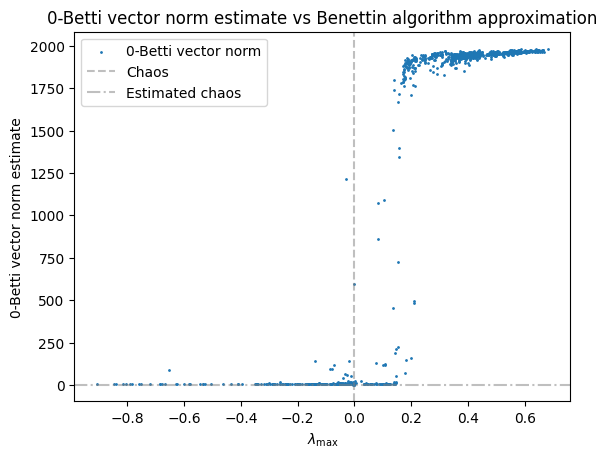

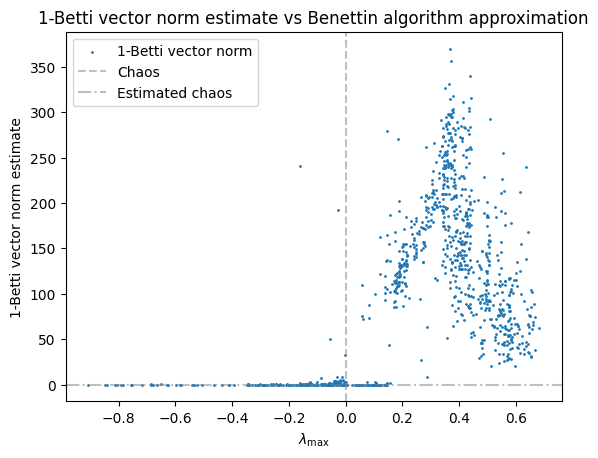

In [43]:
for estimate_name, estimates in zip(crocker_names, betti_estimates_test.T):
    plt.scatter(system_test_data[SYSTEM]["lces"], estimates, s=1, label=estimate_name)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.title(f"{estimate_name} estimate vs Benettin algorithm approximation")
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(f"{estimate_name} estimate")
    plt.legend()
    plt.show()



In [47]:
betti_test_scores_iter = map(partial(get_scores_from_predictions, y_true=y_test), betti_estimates_test.T)
betti_test_scores_df = pd.DataFrame(betti_test_scores_iter)
betti_test_scores_df.index = crocker_names

In [48]:
betti_test_scores_df

,f1,mse_all,mse_chaos,spearmanr_all,spearmanr_chaos,pearsonr_all,pearsonr_chaos
0-Betti vector norm,0.882812,-2.697100e+06,-3.410705e+06,0.917555,0.856295,0.841050,0.625320
1-Betti vector norm,0.913972,-2.023699e+04,-2.548423e+04,0.406108,-0.157935,0.507238,-0.002613


### Supervised learning pipeline with Betti vector norm estimates

We can improve the raw estimates by using them as a feature in a supervised learning pipeline, then predicting $\lambda_{\max}$ using the resulting trained models.

In [49]:
betti_estimates_train = list(lbv.map_sync(get_crocker_estimates, system_training_data[SYSTEM]["trajectories"]))
betti_estimates_train = np.array(betti_estimates_train)

In [50]:
betti_ml_results_train = {SYSTEM: {}}
for result in score_features_train(crocker_names, betti_estimates_train[..., np.newaxis], y_train):
    # print(result)
    betti_ml_results_train[SYSTEM] |= result

In [51]:
betti_ml_train_scores = {k:v["scores"] for k,v in betti_ml_results_train[SYSTEM].items()}
betti_ml_train_models = {k:v["models"] for k,v in betti_ml_results_train[SYSTEM].items()}

In [52]:
# Display the mean scores for the supervised learning using each classic estmate

betti_ml_train_scores_df = pd.DataFrame(betti_ml_train_scores)
betti_ml_train_scores_df_means = betti_ml_train_scores_df.applymap(np.mean).T
betti_ml_train_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
0-Betti vector norm,0.960334,0.959869,-0.006353,-0.004421,-0.019065,-0.005515,-0.024197,-0.007139
1-Betti vector norm,0.965273,0.965468,-0.060207,-0.007307,-0.024598,-0.012944,-0.025719,-0.015727


In [53]:
betti_ml_test_results = {}
for result in score_features_test(crocker_names, betti_estimates_test, y_test, betti_ml_train_models):
        betti_ml_test_results |= result


In [54]:
betti_ml_test_scores = {k:v["r2_scores"] for k,v in betti_ml_test_results.items()}
betti_ml_test_predictions = {k:v["predictions"] for k,v in betti_ml_test_results.items()}    

In [55]:
# Display the mean scores for the supervised learning using each classic estimate

betti_ml_test_scores_df = pd.DataFrame(betti_ml_test_scores)
betti_ml_test_scores_df_means = betti_ml_test_scores_df.applymap(np.mean).T
betti_ml_test_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
0-Betti vector norm,0.958060,0.955204,-0.005243,-0.003847,-0.017351,-0.005282,-0.023113,-0.006219
1-Betti vector norm,0.962818,0.962818,-0.063654,-0.005394,-0.023509,-0.012731,-0.024650,-0.015314


In [76]:
betti_svr_all_predictions = {k: v["SVR_all"] for k, v in betti_ml_test_predictions.items()}

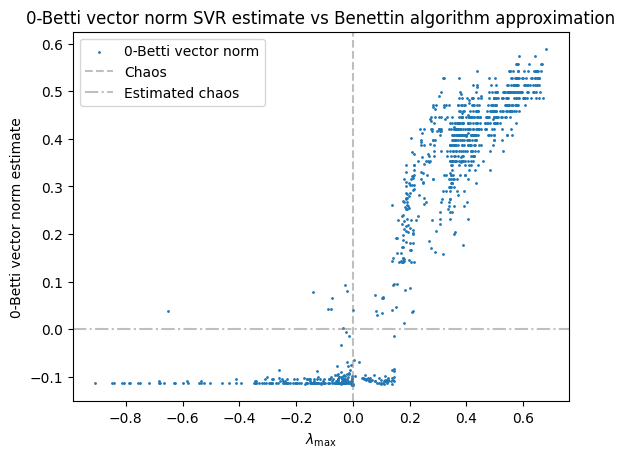

PearsonRResult(statistic=0.8884364919498909, pvalue=0.0)
SignificanceResult(statistic=0.9173383263443142, pvalue=0.0)


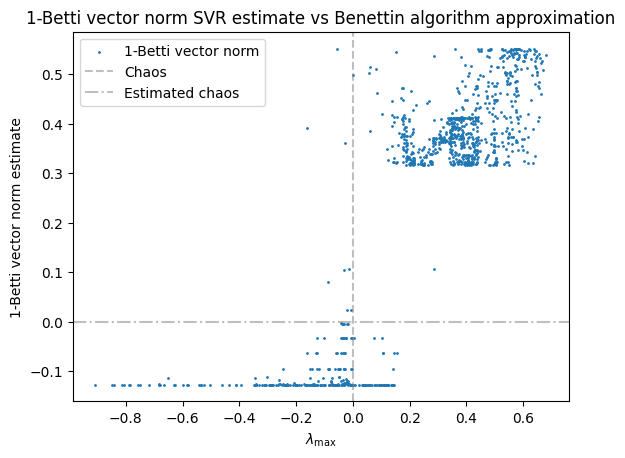

PearsonRResult(statistic=0.8439882703556331, pvalue=1.5987568915963942e-272)
SignificanceResult(statistic=0.7429698697633739, pvalue=2.198097925551241e-176)


In [77]:
for estimate_name, estimates in betti_svr_all_predictions.items():
    lces_true = system_test_data[SYSTEM]["lces"]
    plt.scatter(lces_true, estimates, s=1, label=estimate_name)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.title(f"{estimate_name} SVR estimate vs Benettin algorithm approximation")
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(f"{estimate_name} estimate")
    plt.legend()
    plt.show()
    print(stats.pearsonr(lces_true, estimates))
    print(stats.spearmanr(lces_true, estimates))



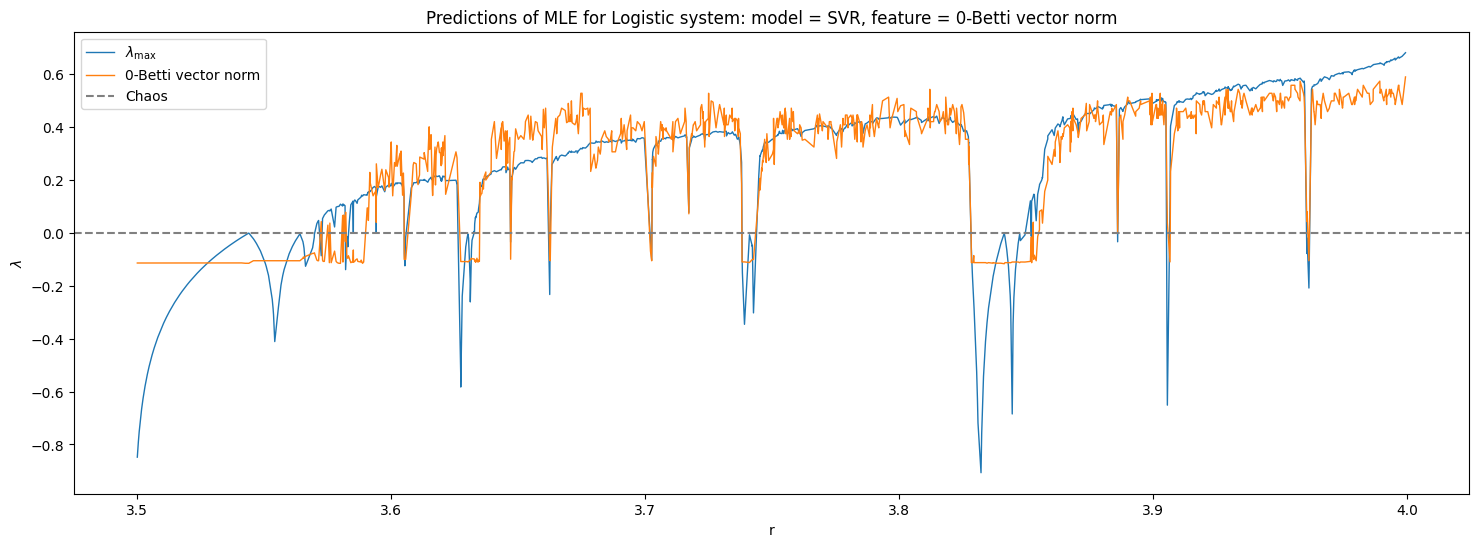

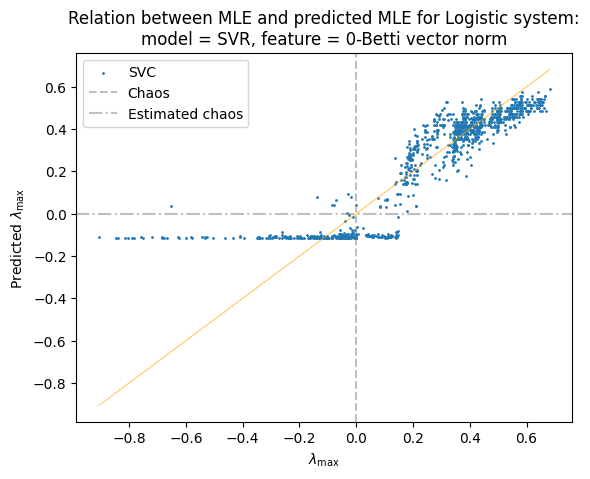

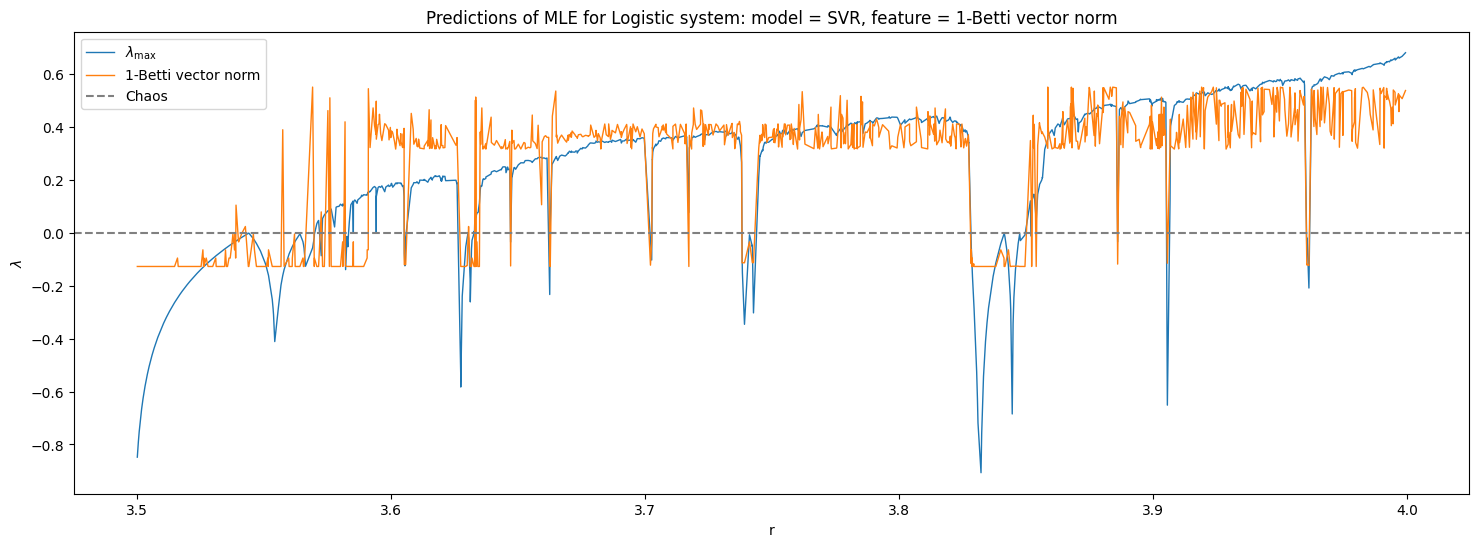

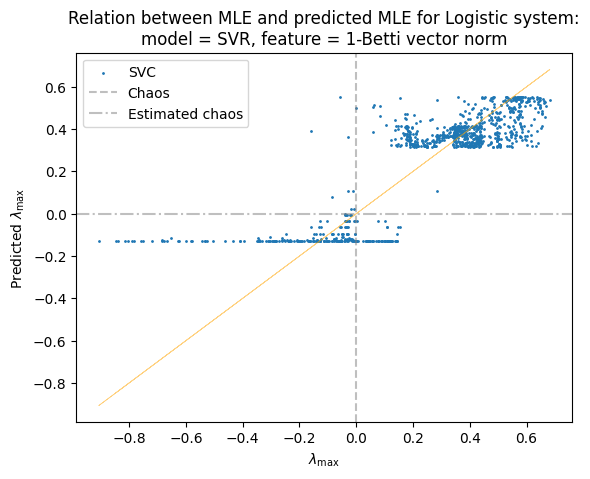

In [78]:
for estimate_name, y_pred in betti_svr_all_predictions.items():
    # plot the ground truth and regression predictions
    plt.figure(figsize=(18,6))
    plt.plot(test_params, y_test, lw=1, label=r"$\lambda_{\max}$")
    # plt.plot(np.array(test_params)[y_test>0], y_pred, lw=1, label=prediction_model_name)
    plt.plot(test_params, y_pred, lw=1, label=estimate_name)
    plt.xlabel(test_param_name)
    plt.ylabel(r"$\lambda$")
    plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
    plt.legend()
    plt.title(f"Predictions of MLE for {SYSTEM.capitalize()} system: model = SVR, feature = {estimate_name}")
    plt.show()

    # plot the relation between prediction and ground truth
    # plt.figure(figsize=(9,6))
    plt.scatter(y_test, y_pred, s=1, label=prediction_model_name)
    plt.plot(y_test, y_test, c="orange", lw=0.5, alpha=0.5)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(r"Predicted $\lambda_{\max}$")
    plt.legend()
    plt.title(f"Relation between MLE and predicted MLE for {SYSTEM.capitalize()} system:\nmodel = SVR, feature = {estimate_name}")
    plt.show()

## Point Summary Estimators

We compute the persistence of kNN and OPN embeddings and report on point summary measures of the diagrams

In [16]:
# import the tda point summary estimators
from point_summary_estimates import get_point_summary_estimates, point_summary_names

### Direct scoring of Betti curve estimates

Estimate $\lambda_{\max}$ for each of the test trajectories. Compute the f1 score for classification, the negative mean squared error (MSE) score for regression, and the Spearman and Pearson correlation coefficients.

In [17]:
point_summary_estimates_test = list(lbv.map_sync(get_point_summary_estimates, system_test_data[SYSTEM]["trajectories"]))
point_summary_estimates_test = np.array(point_summary_estimates_test)


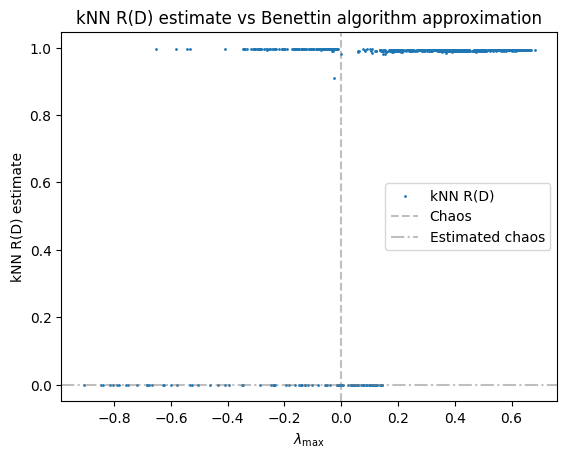

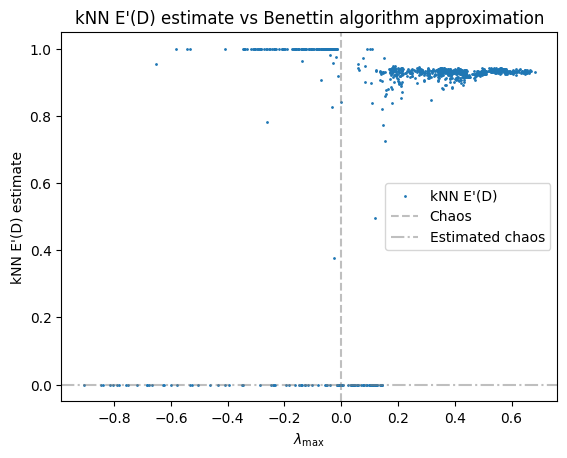

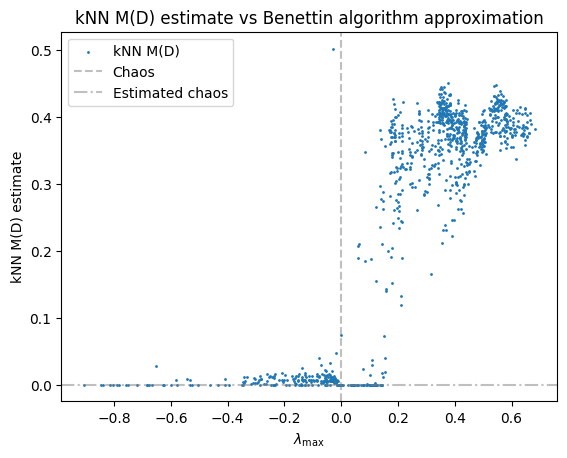

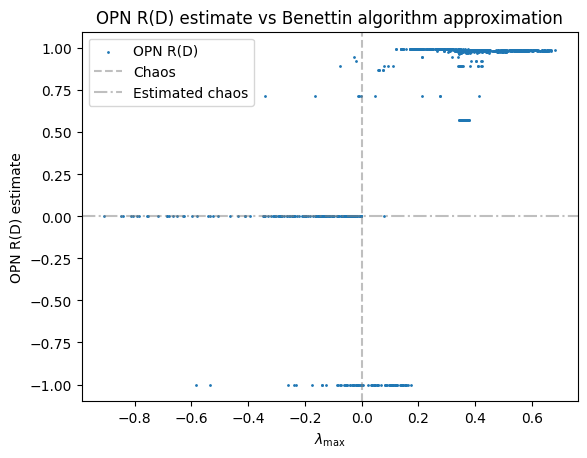

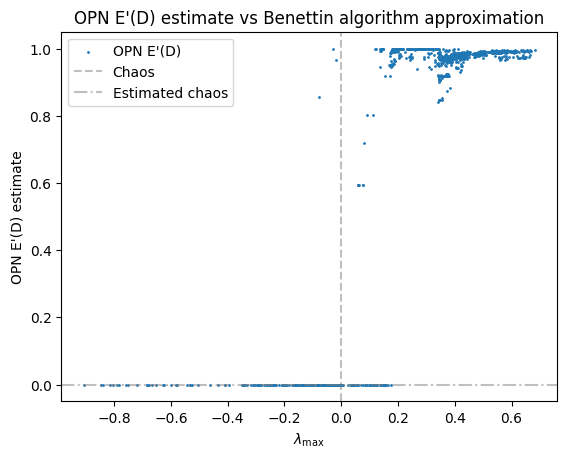

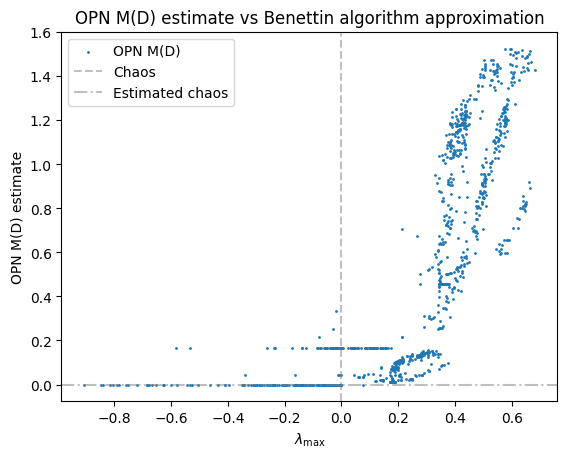

In [18]:
for estimate_name, estimates in zip(point_summary_names, point_summary_estimates_test.T):
    plt.scatter(system_test_data[SYSTEM]["lces"], estimates, s=1, label=estimate_name)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.title(f"{estimate_name} estimate vs Benettin algorithm approximation")
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(f"{estimate_name} estimate")
    plt.legend()
    plt.show()



In [21]:
point_summary_test_scores_iter = map(partial(get_scores_from_predictions, y_true=y_test), point_summary_estimates_test.T)
point_summary_test_scores_df = pd.DataFrame(point_summary_test_scores_iter)
point_summary_test_scores_df.index = point_summary_names

In [22]:
point_summary_test_scores_df

,f1,mse_all,mse_chaos,spearmanr_all,spearmanr_chaos,pearsonr_all,pearsonr_chaos
kNN R(D),0.888889,-0.475417,-0.350912,0.118814,0.560370,0.506314,0.474573
kNN E'(D),0.888889,-0.419457,-0.282016,-0.059386,0.186493,0.461415,0.486595
kNN M(D),0.888889,-0.029507,-0.015142,0.703849,0.448160,0.840702,0.634666
OPN R(D),0.958958,-0.364185,-0.394771,0.471288,-0.023954,0.669939,0.517253
OPN E'(D),0.961413,-0.271244,-0.318195,0.609602,0.245223,0.825875,0.550121
OPN M(D),0.972308,-0.201216,-0.230132,0.893626,0.834331,0.764563,0.821028


### Supervised learning pipeline with kNN and OPN persistence point summaries

We can improve the raw estimates by using them as a feature in a supervised learning pipeline, then predicting $\lambda_{\max}$ using the resulting trained models.

In [23]:
point_summary_estimates_train = list(lbv.map_sync(get_point_summary_estimates, system_training_data[SYSTEM]["trajectories"]))
point_summary_estimates_train = np.array(point_summary_estimates_train)

In [24]:
point_summary_ml_results_train = {SYSTEM: {}}
for result in score_features_train(point_summary_names, point_summary_estimates_train[..., np.newaxis], y_train):
    # print(result)
    point_summary_ml_results_train[SYSTEM] |= result

/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/TDA/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/TDA/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/TDA/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ab5169/miniconda3/envs/chaos-chapter/lib/python3.10/site-packages/teaspoon/TDA/../../sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarn

In [25]:
point_summary_ml_train_scores = {k:v["scores"] for k,v in point_summary_ml_results_train[SYSTEM].items()}
point_summary_ml_train_models = {k:v["models"] for k,v in point_summary_ml_results_train[SYSTEM].items()}

In [26]:
# Display the mean scores for the supervised learning using each classic estmate

point_summary_ml_train_scores_df = pd.DataFrame(point_summary_ml_train_scores)
point_summary_ml_train_scores_df_means = point_summary_ml_train_scores_df.applymap(np.mean).T
point_summary_ml_train_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
kNN R(D),0.966940,0.889103,-0.065205,-0.013527,-0.045093,-0.015749,-0.060460,-0.016743
kNN E'(D),0.966004,0.966093,-0.069536,-0.016839,-0.029037,-0.016296,-0.027445,-0.015915
kNN M(D),0.965893,0.965891,-0.063494,-0.014605,-0.024864,-0.013405,-0.024679,-0.013358
OPN R(D),0.972858,0.972858,-0.073924,-0.015913,-0.023105,-0.011309,-0.027934,-0.016151
OPN E'(D),0.961022,0.961022,-0.113378,-0.010225,-0.026683,-0.014023,-0.026845,-0.015150
OPN M(D),0.960555,0.937073,-0.066283,-0.005762,-0.021262,-0.006000,-0.027873,-0.006067


In [27]:
point_summary_ml_test_results = {}
for result in score_features_test(point_summary_names, point_summary_estimates_test, y_test, point_summary_ml_train_models):
        point_summary_ml_test_results |= result


In [28]:
point_summary_ml_test_scores = {k:v["r2_scores"] for k,v in point_summary_ml_test_results.items()}
point_summary_ml_test_predictions = {k:v["predictions"] for k,v in point_summary_ml_test_results.items()}    

In [29]:
# Display the mean scores for the supervised learning using each classic estimate

point_summary_ml_test_scores_df = pd.DataFrame(point_summary_ml_test_scores)
point_summary_ml_test_scores_df_means = point_summary_ml_test_scores_df.applymap(np.mean).T
point_summary_ml_test_scores_df_means.style.highlight_max(color='yellow', axis=0)

,SVC,MLPC,KNR_all,KNR_chaos,SVR_all,SVR_chaos,MLPR_all,MLPR_chaos
kNN R(D),0.965607,0.888889,-0.062997,-0.015223,-0.056167,-0.016307,-0.060165,-0.017396
kNN E'(D),0.963777,0.963059,-0.066613,-0.017682,-0.027027,-0.016012,-0.026154,-0.016175
kNN M(D),0.964706,0.964029,-0.060427,-0.013312,-0.023559,-0.013354,-0.023393,-0.013314
OPN R(D),0.972308,0.972308,-0.067671,-0.016094,-0.022303,-0.011642,-0.025758,-0.016406
OPN E'(D),0.961413,0.961413,-0.114522,-0.008898,-0.025665,-0.014188,-0.025689,-0.015315
OPN M(D),0.958853,0.932476,-0.058975,-0.005883,-0.019039,-0.005723,-0.025278,-0.005737


In [30]:
point_summary_svr_all_predictions = {k: v["SVR_all"] for k, v in point_summary_ml_test_predictions.items()}

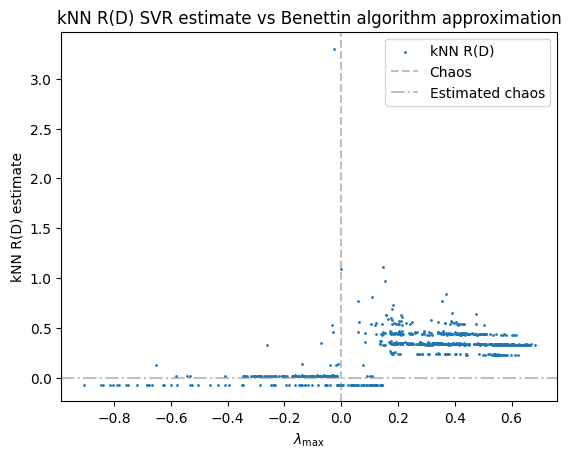

PearsonRResult(statistic=0.5796018168527352, pvalue=6.77936074737623e-91)
SignificanceResult(statistic=0.34096831994520366, pvalue=1.1358980671498532e-28)


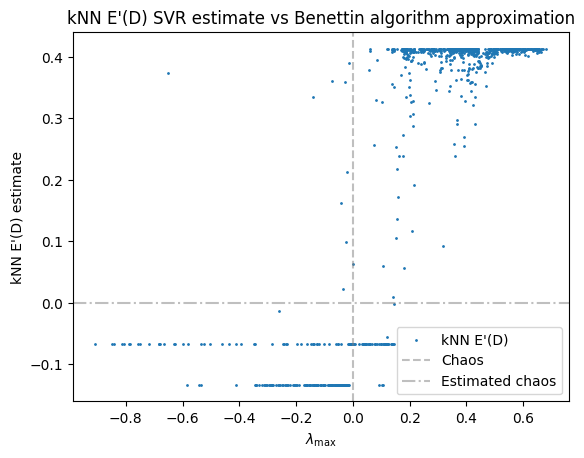

PearsonRResult(statistic=0.8193639895964852, pvalue=1.2358372626232657e-243)
SignificanceResult(statistic=0.663456533091854, pvalue=5.394739298240819e-128)


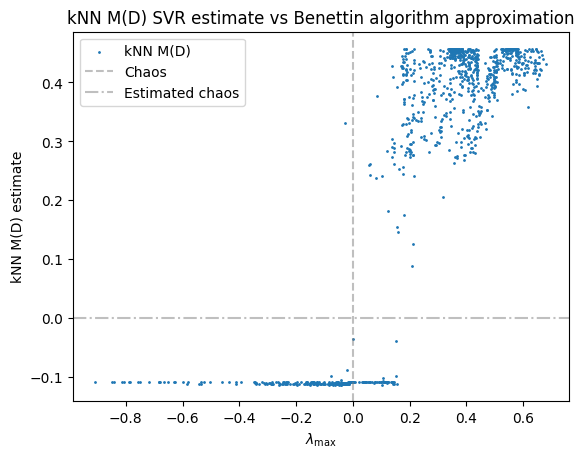

PearsonRResult(statistic=0.8437367452936396, pvalue=3.3402333821334795e-272)
SignificanceResult(statistic=0.7141277170280265, pvalue=6.461940021762747e-157)


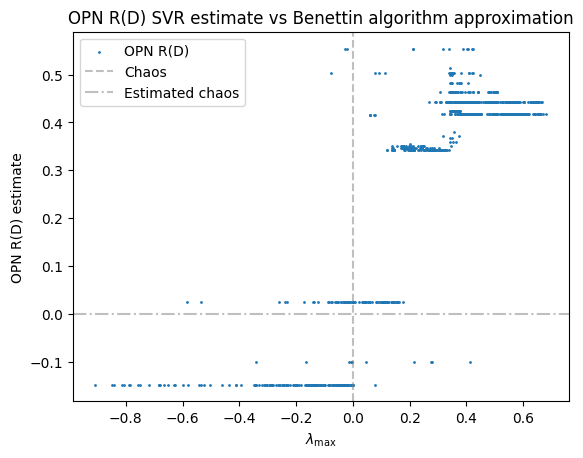

PearsonRResult(statistic=0.8563457424266958, pvalue=5.558240340710149e-289)
SignificanceResult(statistic=0.7447538746451277, pvalue=1.1272139898749897e-177)


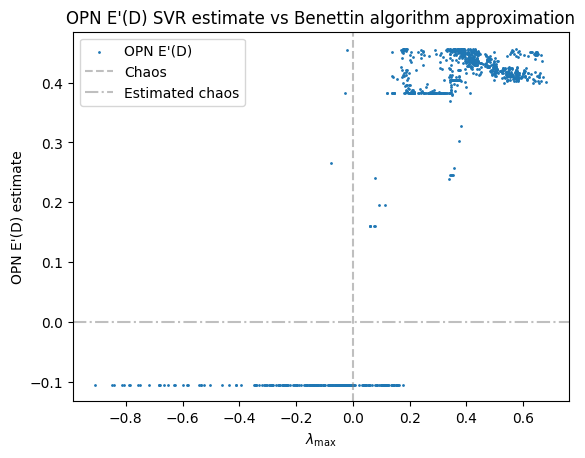

PearsonRResult(statistic=0.8300084793215502, pvalue=1.5014494606667168e-255)
SignificanceResult(statistic=0.6662718284224163, pvalue=1.882116269346728e-129)


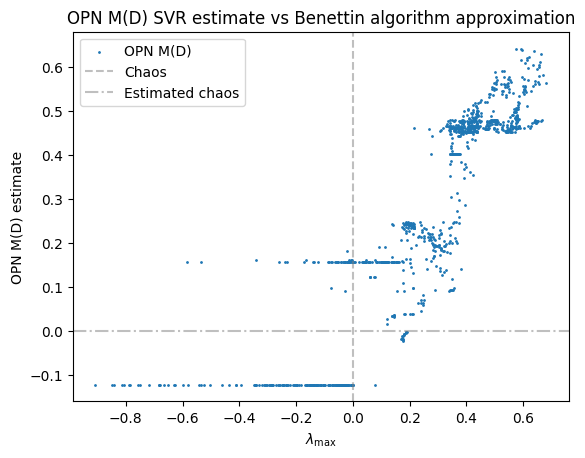

PearsonRResult(statistic=0.8804638628723098, pvalue=0.0)
SignificanceResult(statistic=0.9112437539749743, pvalue=0.0)


In [31]:
for estimate_name, estimates in point_summary_svr_all_predictions.items():
    lces_true = system_test_data[SYSTEM]["lces"]
    plt.scatter(lces_true, estimates, s=1, label=estimate_name)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.title(f"{estimate_name} SVR estimate vs Benettin algorithm approximation")
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(f"{estimate_name} estimate")
    plt.legend()
    plt.show()
    print(stats.pearsonr(lces_true, estimates))
    print(stats.spearmanr(lces_true, estimates))



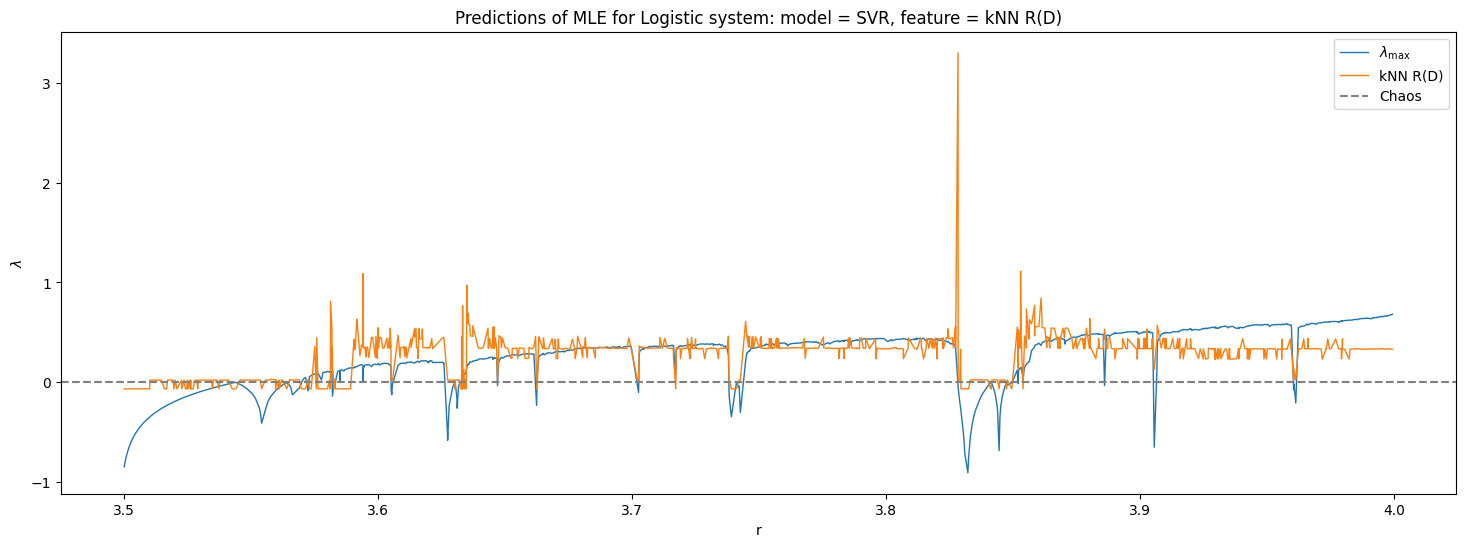

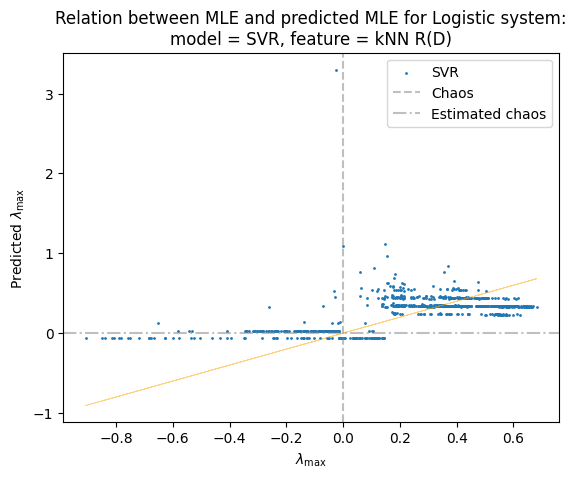

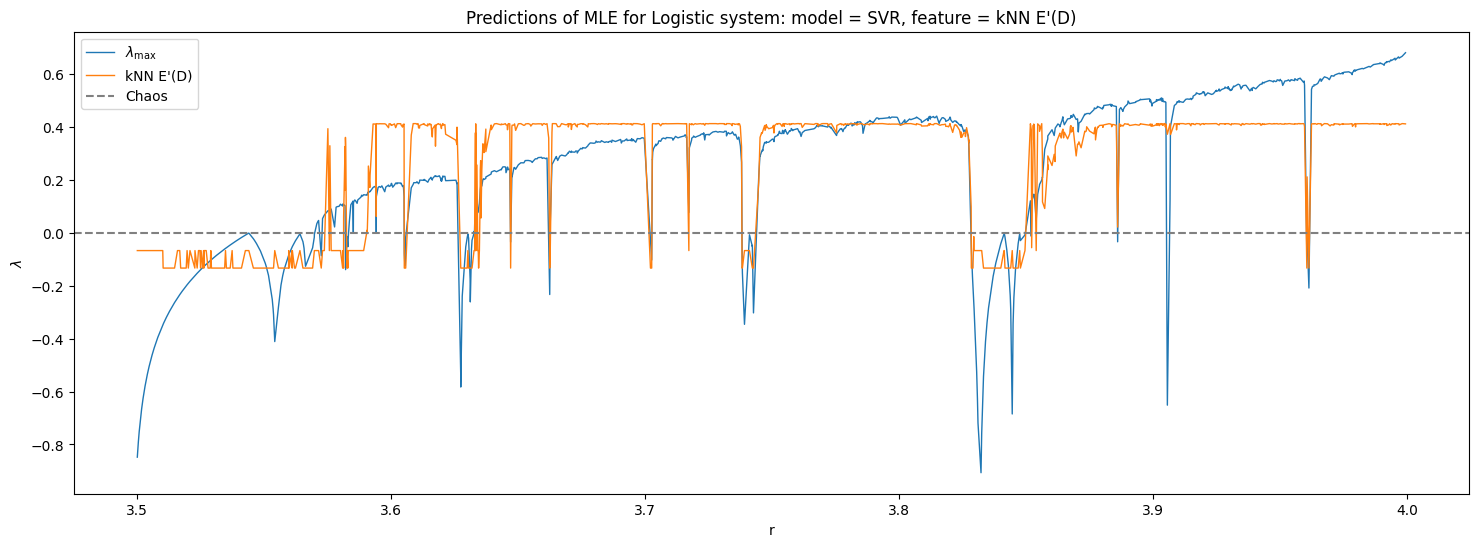

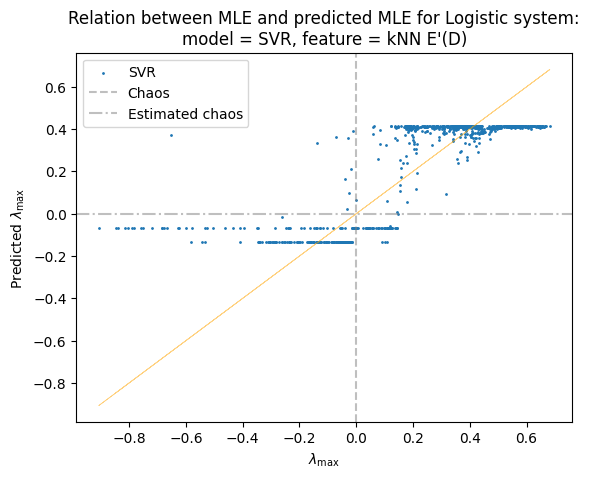

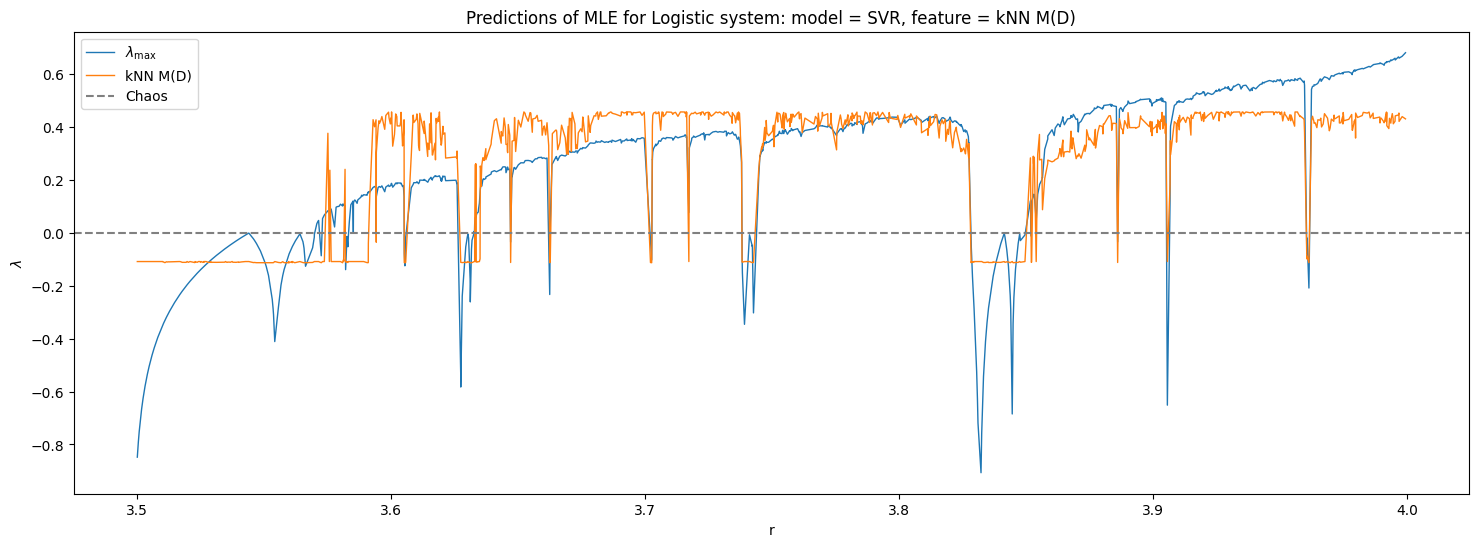

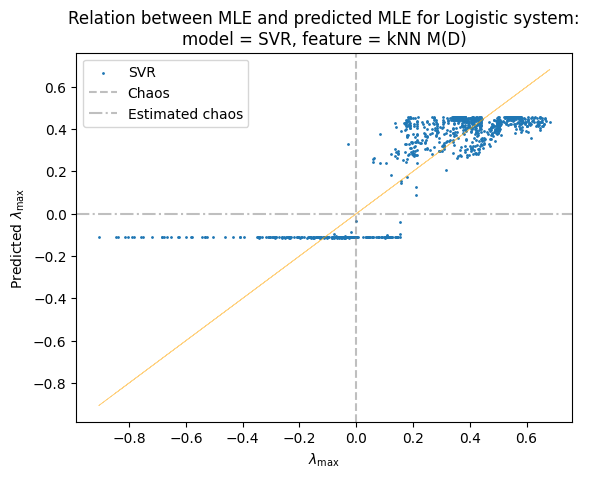

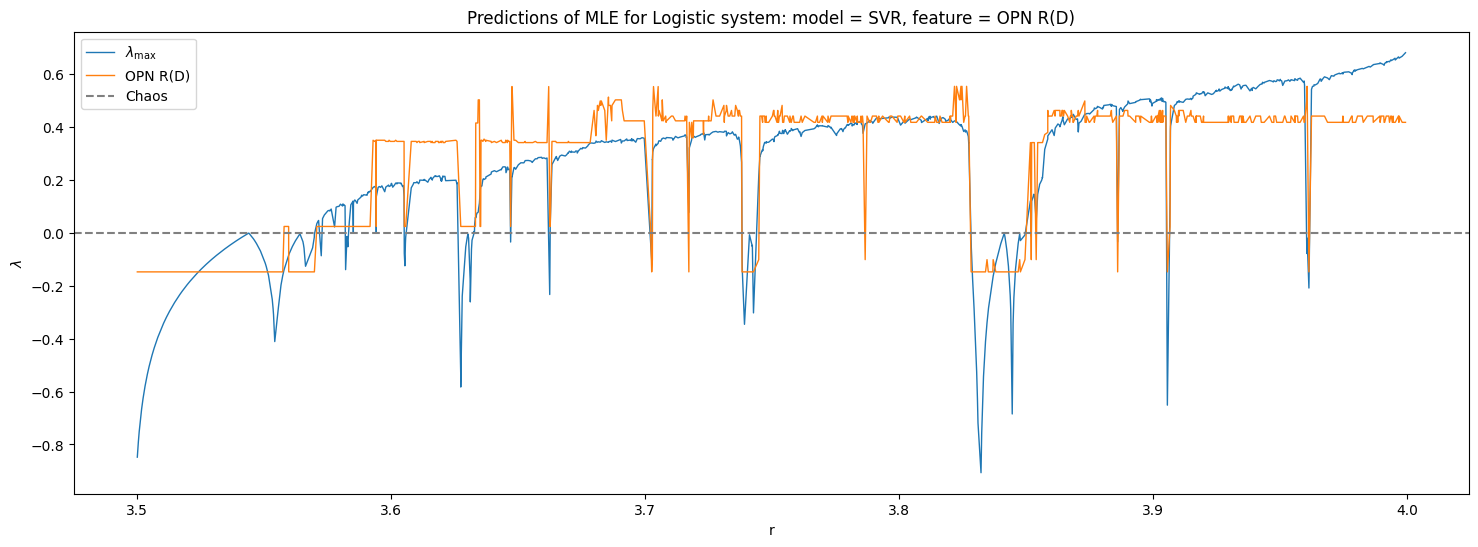

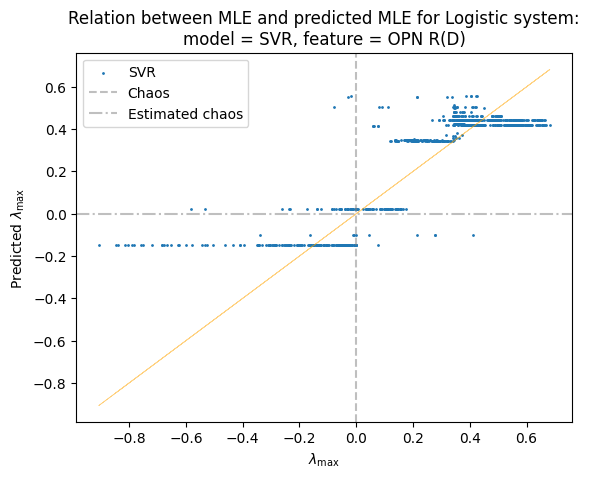

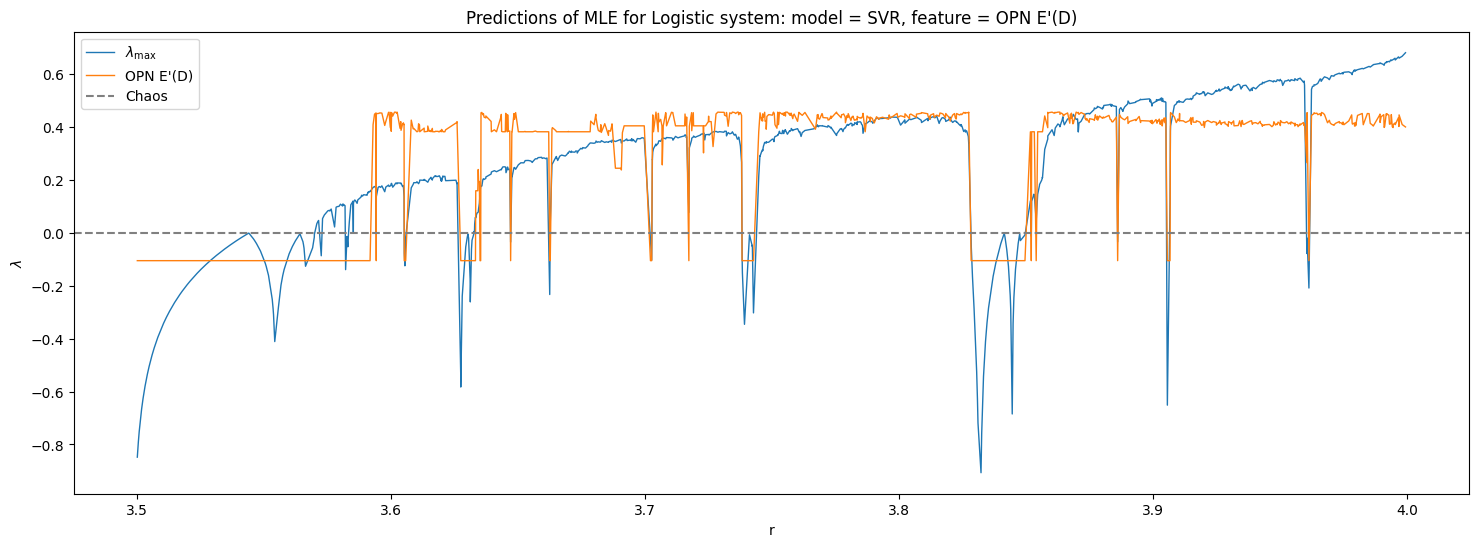

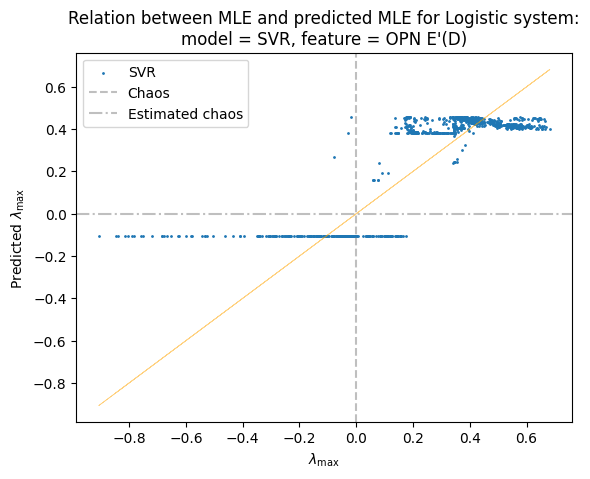

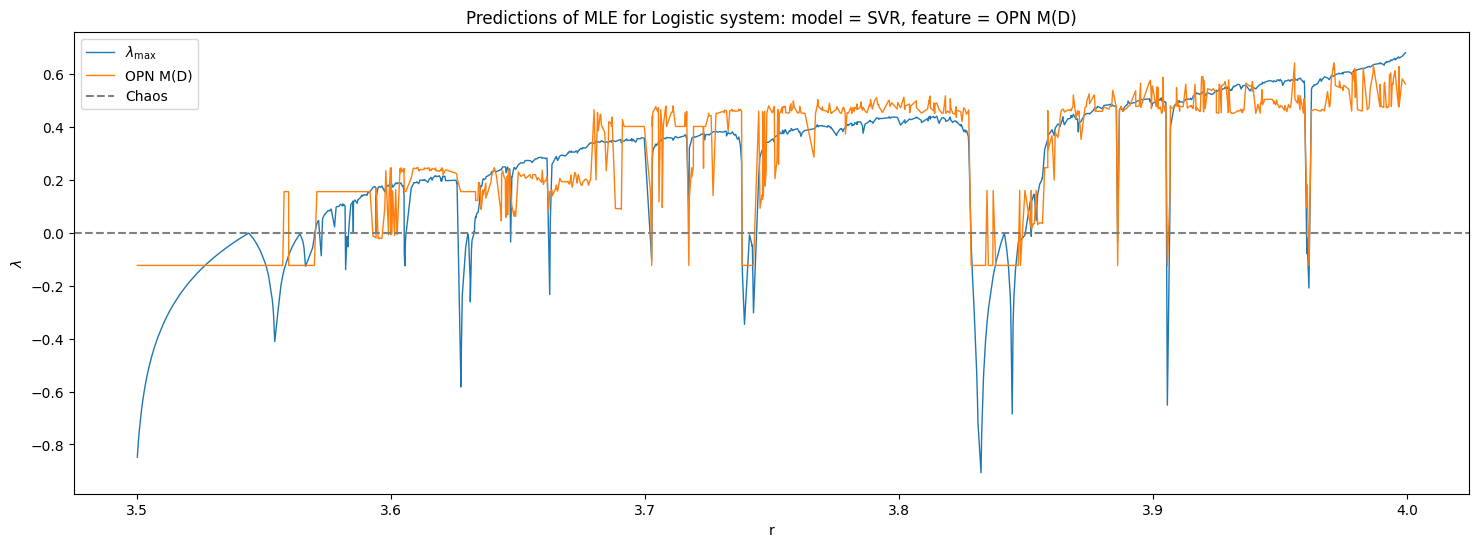

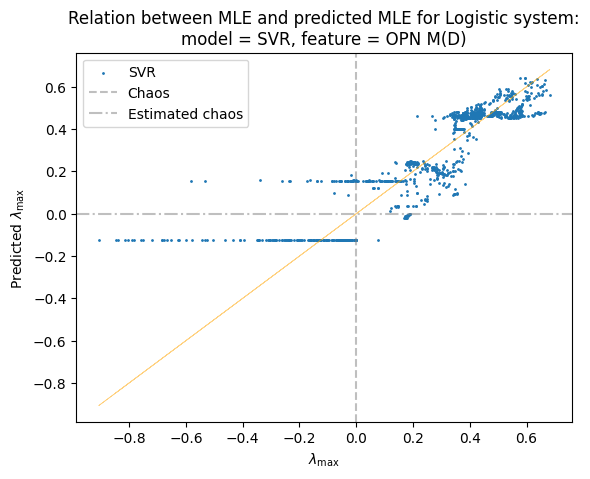

In [33]:
for estimate_name, y_pred in point_summary_svr_all_predictions.items():
    # plot the ground truth and regression predictions
    plt.figure(figsize=(18,6))
    plt.plot(test_params, y_test, lw=1, label=r"$\lambda_{\max}$")
    # plt.plot(np.array(test_params)[y_test>0], y_pred, lw=1, label=prediction_model_name)
    plt.plot(test_params, y_pred, lw=1, label=estimate_name)
    plt.xlabel(test_param_name)
    plt.ylabel(r"$\lambda$")
    plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
    plt.legend()
    plt.title(f"Predictions of MLE for {SYSTEM.capitalize()} system: model = SVR, feature = {estimate_name}")
    plt.show()

    # plot the relation between prediction and ground truth
    # plt.figure(figsize=(9,6))
    plt.scatter(y_test, y_pred, s=1, label="SVR")
    plt.plot(y_test, y_test, c="orange", lw=0.5, alpha=0.5)
    plt.axvline(0, ls="--", c="gray", label="Chaos", alpha=0.5)
    plt.axhline(0, ls="-.", c="gray", label="Estimated chaos", alpha=0.5)
    plt.xlabel(r"$\lambda_{\max}$")
    plt.ylabel(r"Predicted $\lambda_{\max}$")
    plt.legend()
    plt.title(f"Relation between MLE and predicted MLE for {SYSTEM.capitalize()} system:\nmodel = SVR, feature = {estimate_name}")
    plt.show()